# 1. Data preparation and exploration (35%)

## 1.1 Creating Spark Session (4%)

In [1]:
# TODO: Create SparkSession
# TODO: Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from  pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import pandas as pd
from heatmap import heatmap, corrplot
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from datetime import datetime
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

from pyspark.sql.types import IntegerType, DateType, StringType, FloatType, StructType, StructField
# TODO: Create Spark Configuration Object
master = "local[*]"
app_name = "Detecting Linux system hacking activities"
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.files.maxPartitionBytes",31457280)

# Create SparkSession

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

sc = spark.sparkContext


sc.setLogLevel('ERROR')

from pyspark.sql.functions import isnan, when, count, col

In [2]:
pd.set_option('display.float_format', lambda y: '%.3f' % y)

## 1.2 Loading the data (16%)

In [3]:
schema1 = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("MINFLT", StringType()),
    StructField("MAJFLT", StringType()),
    StructField("VSTEXT", StringType()),
    StructField("VSIZE", FloatType()),
    StructField("RSIZE", StringType()),
    StructField("VGROW", StringType()),
    StructField("RGROW", StringType()),
    StructField("MEM", FloatType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType())
])

schema2 = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("TRUN", IntegerType()),
    StructField("TSLPI", IntegerType()),
    StructField("TSLPU", IntegerType()),
    StructField("POLI", StringType()),
    StructField("NICE", IntegerType()),
    StructField("PRI", IntegerType()),
    StructField("RTPR", IntegerType()),
    StructField("CPUNR", IntegerType()),
    StructField("Status", StringType()),
    StructField("EXC", IntegerType()),
    StructField("State", StringType()),
    StructField("CPU", FloatType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType())
])



#Load the CSV File
df_memory = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('linux_memory_*.csv',schema=schema1).cache()
#Load the CSV File
df_process = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('linux_process_*.csv',schema=schema2).cache()

In [4]:
df_memory.is_cached


True

In [5]:
df_process.is_cached

True

In [6]:
df_memory.rdd.getNumPartitions()

4

In [7]:
df_process.rdd.getNumPartitions()

5

In [8]:
# row count of memory
df_memory.count()

2000000

In [9]:
df_memory.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: float (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [10]:
df_process.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [11]:
#row count of process
df_process.count()

1927968

In [12]:
df_process.filter(df_process.PRI >= 100).filter(df_process.PRI <= 119).show()

+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+----+------+------+
|        ts| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State| CPU| CMD|attack|  type|
+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+----+------+------+
|1556739968|3897|   0|    1|    0|norm|  20|100|   0|    2|     -|  0|    S|0.01|atop|     0|normal|
|1556739973|3894|   1|    0|    0|norm|  20|100|   0|    1|     -|  0|    R|0.01|atop|     0|normal|
|1556739978|3896|   0|    1|    0|norm|  20|100|   0|    2|     -|  0|    S|0.01|atop|     0|normal|
|1556739983|3895|   0|    1|    0|norm|  20|100|   0|    1|     -|  0|    S|0.01|atop|     0|normal|
|1556740123|3896|   0|    1|    0|norm|  20|100|   0|    2|     -|  0|    S|0.01|atop|     0|normal|
|1556740128|3895|   0|    1|    0|norm|  20|100|   0|    2|     -|  0|    S|0.01|atop|     0|normal|
|1556740133|3894|   1|    0|    0|norm|  20|100|   0|    1|     -|  0|    R|0.01|atop|     

In [13]:
df_process = df_process.withColumn('NICE',when((col('PRI') >= 100) & (col('PRI') <= 119)\
                                  ,col('NICE')*-1 ).otherwise(col("NICE"))).orderBy("NICE")

In [14]:
#df_process.filter(df_process.PRI == 139).show()

In [15]:
#checking missing/null values

from pyspark.sql.functions import isnan, when, count, col


df_memory.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_memory.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [16]:
#finding non numeric strings in some of memory dataframe columns

df_memory.createOrReplaceTempView("sql_memory")

spark.sql("select distinct MINFLT from sql_memory where MINFLT not rlike '^[0-9.]*$'").show()


+------+
|MINFLT|
+------+
|    0K|
|  132K|
+------+



In [17]:
#replacing non numeric characters in the strings to "" -> nothing, then converting back to integer

df_memory = df_memory.withColumn("MINFLT", regexp_replace("MINFLT", "K", "000"))

In [18]:
spark.sql("select distinct MAJFLT from sql_memory where MAJFLT not rlike '^[0-9.]*$'").show()

+------+
|MAJFLT|
+------+
|224.2M|
|224.4M|
+------+



In [19]:
df_memory = df_memory.withColumn("MAJFLT", regexp_replace("MAJFLT", "224.2M", "224200000"))
df_memory = df_memory.withColumn("MAJFLT", regexp_replace("MAJFLT", "224.4M", "224400000"))

In [20]:
spark.sql("select distinct VSTEXT from sql_memory where VSTEXT not rlike '^[0-9.]*$'").show(1000)

+------+
|VSTEXT|
+------+
|10976K|
|11168K|
|11136K|
|11004K|
|10980K|
| 9372K|
| 9368K|
|11188K|
| 9392K|
|11152K|
| 9384K|
| 9360K|
|10988K|
| 9168K|
| 9356K|
|11156K|
|11108K|
|11160K|
|11196K|
|11200K|
|11192K|
|11180K|
|11164K|
| 9352K|
| 9192K|
| 9388K|
|11184K|
| 9364K|
|11172K|
|11092K|
| 9376K|
| 9176K|
|10956K|
| 9380K|
|11176K|
+------+



In [21]:
df_memory = df_memory.withColumn("VSTEXT", regexp_replace("VSTEXT", "K", "000"))

In [22]:
spark.sql("select distinct RSIZE from sql_memory where RSIZE not rlike '^[0-9.]*$'").show(1000)

+------+
| RSIZE|
+------+
|    -4|
| -1056|
| -2048|
|  -192|
|  -160|
| -8192|
| -1376|
|  -512|
|  -480|
| -1024|
|  -960|
| -1248|
| -2176|
| -1792|
| -1088|
|  -768|
| -6656|
|    0K|
| -1120|
|  -832|
|  -184|
|  -992|
| -6144|
| -1148|
| -2432|
|  -576|
| -1216|
| -2016|
| -1504|
| -2080|
|  -564|
| -1856|
| -2208|
|  -704|
| -1280|
|   16K|
| -1312|
| -2240|
| -2336|
| -2144|
| -1512|
| -1600|
|  -0.2|
| -1472|
|   -64|
| -4096|
| -2656|
|  -128|
|  -864|
|   -56|
| -9216|
|  -320|
|  -928|
|224.2M|
|  -288|
|   -12|
|  -736|
| -2272|
|   -32|
| -7168|
| -1344|
| -1008|
|  -896|
| -1824|
|  -640|
|   -16|
| -1728|
| -2464|
| -1408|
| -1440|
| -1488|
| -1020|
|  -608|
| -2304|
| -2368|
| -12.5|
|  -196|
| -1608|
| -49.3|
|  -672|
| -1568|
| -1632|
|  -384|
| -2592|
|  -352|
| -1536|
|  -800|
| -1696|
| -1664|
|   -20|
|   -84|
|224.4M|
|   -28|
|   -24|
| -1952|
| -8704|
|   -36|
| -27.1|
| -2560|
| -1888|
| -1184|
|  216K|
| -1984|
|  -0.8|
|  -256|
| -9728|
| -1920|
| -1364|
|

In [23]:
df_memory = df_memory.withColumn("RSIZE", regexp_replace("RSIZE", "K", "000"))
df_memory = df_memory.withColumn("RSIZE", regexp_replace("RSIZE", "224.2M", "224200000"))
df_memory = df_memory.withColumn("RSIZE", regexp_replace("RSIZE", "224.4M", "224400000"))

In [24]:
# dataframe
df_memory.select(col("VSTEXT")).distinct().show(10000)

+--------+
|  VSTEXT|
+--------+
|    6240|
|   812.2|
|   24504|
|   10096|
|    2904|
|   59652|
|   54816|
|    7252|
|    4032|
|    1512|
|   22728|
|   72472|
|   181.9|
|   62912|
|   81824|
|   268.3|
|   10436|
|   118.5|
|     296|
|   92072|
|   176.4|
|   437.4|
|   352.4|
|    2756|
|   28524|
|    2464|
|    1372|
|   81808|
|     944|
|   212.2|
|   82604|
|   87664|
|   105.7|
|     125|
|   388.7|
|   176.9|
|   15052|
|   94336|
|   63316|
|   36260|
|   383.2|
|   17256|
|   16340|
|   15420|
|    2700|
|    5044|
|    2696|
|   82768|
|     2.6|
|    3200|
|   72856|
|   72752|
|   81304|
|   244.1|
|   254.1|
|   130.3|
|   261.2|
|   477.8|
|   131.6|
|   33500|
|   331.2|
|   99528|
|   96196|
|    7056|
|       7|
|     124|
|    6252|
|   230.4|
|   438.2|
|   29580|
|    4236|
|    4276|
|    1528|
|    5320|
|   33120|
|   170.4|
|   81232|
|   192.2|
|   263.5|
|    9196|
|   403.8|
|    4988|
|   105.3|
|   54940|
|   299.7|
|    6768|
|   21556|
|    9544|

In [25]:
spark.sql("select distinct VGROW from sql_memory where VGROW not rlike '^[0-9.]*$'").show(2000)

+-------+
|  VGROW|
+-------+
|     -4|
|019.9 3|
|43420 5|
|15692 1|
| 7560 3|
|  052 6|
| 1264 3|
|   -212|
| 7400 1|
| 1032 3|
| 0152 1|
|  324 6|
|  100 3|
|15356 2|
|  176 1|
|  -10.9|
| 0156 1|
| 0128 1|
|  056 6|
| 1452 2|
|   16 5|
|  108 3|
| 1156 3|
| 1460 1|
|   -348|
| 0264 3|
|  056 7|
|  052 4|
|   48 3|
| 0388 3|
|  104 1|
|   -192|
| 0644 1|
|21624 7|
|19088 2|
|  020 5|
|   28 3|
| 0236 2|
|  -5440|
|  224 6|
| 3260 3|
|  336 3|
| 0408 2|
| 1216 7|
| 00.1 1|
|  012 6|
|18468 5|
| 0580 3|
|  944 3|
|  312 3|
|  024 3|
|   28 1|
|   -404|
|057.3 1|
|13456 5|
|  012 2|
| 0108 1|
|20064 2|
| 0364 3|
|  -8652|
|  -8064|
|  1764K|
|  1760K|
| 6864 8|
| 00.1 2|
|  168 1|
| 1324 1|
|  388 3|
|   -160|
|019.8 2|
|019.3 2|
|   -892|
|   -568|
|  144 5|
|  376 7|
| 1380 3|
|  108 1|
| 4992 2|
|  220 7|
|03592 6|
| 9496 5|
| 0216 1|
|  -4396|
|   -664|
|   -368|
|09256 1|
|31964 5|
| 4980 5|
| 6024 2|
| 1572 3|
|   -460|
| 0468 6|
|01664 3|
|  196 6|
| 0216 6|
| 0436 3|
|01188 3|


In [26]:
spark.sql("select distinct VGROW from sql_memory where VGROW not rlike '^[0-9. ]*$'").show(2000)

+------+
| VGROW|
+------+
|    -4|
|  -212|
| -10.9|
|  -348|
|  -192|
| -5440|
|  -404|
| -8652|
| -8064|
| 1764K|
| 1760K|
|  -160|
|  -892|
|  -568|
| -4396|
|  -664|
|  -368|
|  -460|
|  -396|
|  -480|
| -19.6|
|  -588|
|  -180|
|  -692|
| -1012|
| -1516|
|  -116|
| 9372K|
|  -456|
|  -224|
|  -440|
|  -136|
| 9368K|
| -11.1|
|  -484|
|  -220|
|    0K|
|  -688|
|  -184|
|  -656|
|   20K|
|  -152|
|  -104|
|  -200|
|    -8|
|  -612|
|  -376|
|  -628|
| 9392K|
| -1508|
| 1768K|
|  -680|
|  -124|
|  -452|
|  -308|
|  -704|
|  -488|
|  -432|
|  -132|
|   16K|
| -56.6|
|  -660|
| 1820K|
| -1496|
|  -400|
|  -312|
|  -112|
|  -528|
|  -144|
|  -176|
| 9384K|
|  -272|
|   -64|
| 9360K|
| -1928|
| -1676|
|  -168|
|  -944|
|  -128|
| -50.4|
|  -696|
|   -56|
| -4480|
| -45.1|
|  -828|
|-9384K|
|  -584|
| 9356K|
|-9392K|
|11160K|
|  -408|
| -10.3|
|  -320|
| -1180|
|  -100|
|  -928|
| 1800K|
|   -12|
|  -532|
| -1384|
|  -468|
|   -32|
|  -668|
|  -316|
|   -57|
|  -748|
|  -292|
| 1700K|
|

In [27]:
df_memory = df_memory.withColumn("VGROW", regexp_replace("VGROW", " ", ""))
df_memory = df_memory.withColumn("VGROW", regexp_replace("VGROW", "K", "000"))


In [28]:
spark.sql("select distinct RGROW from sql_memory where RGROW not rlike '^[0-9.]*$'").show()

+-----+
|RGROW|
+-----+
|   0K|
+-----+



In [29]:
df_memory = df_memory.withColumn("RGROW", regexp_replace("RGROW", "0K", "000"))

In [30]:
df_memory.select(col("RGROW")).distinct().show(10000)

+-----+
|RGROW|
+-----+
|  296|
| 6240|
| 7252|
| 2904|
| 1512|
| 2136|
| 4032|
|16576|
|11888|
| 10.7|
|16320|
|13192|
| 1572|
| 1436|
| 7328|
| 69.3|
|  944|
| 45.4|
| 1372|
|  800|
| 3368|
| 20.5|
|15448|
| 2464|
| 6248|
|32660|
| 47.5|
| 5044|
| 6848|
| 3200|
| 1808|
| 7784|
| 1280|
|97180|
| 8832|
| 2696|
| 38.5|
| 63.2|
| 3836|
| 7056|
|  124|
| 4236|
| 3312|
| 2888|
| 6768|
| 6732|
| 9196|
| 1528|
| 3652|
| 4276|
| 4988|
| 6252|
|34316|
|14392|
| 5048|
| 6348|
|54344|
| 4464|
| 7544|
| 1500|
|17168|
|20856|
| 7316|
|13180|
| 6464|
| 5052|
| 4736|
| 4672|
| 9296|
|  740|
| 4980|
| 4776|
| 9980|
|  544|
| 1880|
| 14.2|
| 8680|
| 12.8|
| 16.6|
|14432|
|12508|
|23468|
| 2808|
| 3848|
| 6264|
| 3656|
|  272|
| 1104|
| 5104|
| 17.1|
| 1956|
|109.6|
|17348|
| 30.1|
| 2948|
| 26.7|
| 6212|
| 2980|
| 2200|
|11600|
| 2392|
|67156|
| 3408|
| 4408|
| 2964|
| 5412|
|  232|
|15100|
|101.4|
| 2144|
|  700|
| 3280|
|  448|
| 7980|
|14868|
|18504|
|20020|
| 1008|
|16668|
|10484|
|20064|
| 40.1|


In [31]:
#spark.sql("select * from sql_memory where MINFLT rlike '[^0-9]'").show()

In [32]:
#spark.sql(UPDATE {sql_memory} SET {MINFLT} = REGEXP_REPLACE({MINFLT}, '[^0-9a-zA-Z ]', '')).show()

In [33]:
#replacing non numeric characters in the strings to "" -> nothing, then converting back to integer


df_memory = df_memory.withColumn("MINFLT", df_memory["MINFLT"].cast(FloatType()))
df_memory = df_memory.withColumn("MAJFLT", df_memory["MAJFLT"].cast(FloatType()))
df_memory = df_memory.withColumn("VSTEXT", df_memory["VSTEXT"].cast(FloatType()))
df_memory = df_memory.withColumn("RSIZE", df_memory["RSIZE"].cast(FloatType()))
df_memory = df_memory.withColumn("VGROW", df_memory["VGROW"].cast(FloatType()))
df_memory = df_memory.withColumn("RGROW", df_memory["RGROW"].cast(FloatType()))



In [34]:
df_memory.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_memory.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [35]:
df_memory.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: float (nullable = true)
 |-- MAJFLT: float (nullable = true)
 |-- VSTEXT: float (nullable = true)
 |-- VSIZE: float (nullable = true)
 |-- RSIZE: float (nullable = true)
 |-- VGROW: float (nullable = true)
 |-- RGROW: float (nullable = true)
 |-- MEM: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [36]:
df_process.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_process.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



# 1.3 Exploring the data (15%)

## Show the count of attack and non-attack in each activity based on the column “attack”

In [37]:
#count of attack in memory
df_memory[df_memory['attack'] == 0].count()

1794377

In [38]:
#count of non attack in memory

df_memory[df_memory['attack'] == 1].count()

205623

In [39]:
#count of attack in process
df_process[df_process['attack'] == 0].count()

1636604

In [40]:
#count of non attack in process
df_process[df_process['attack'] == 1].count()

291364

## show the count of each kind of attack in process activity based on the column “type”.

In [41]:
##1. Show the count of attack and non-attack in each activity based on the column
#“attack”, then show the count of each kind of attack in process activity based on the
#column “type”.
#○ Do you see any class imbalance? Examine and describe what you observe

In [42]:
df_process.groupBy("type").count().show()

+---------+-------+
|     type|  count|
+---------+-------+
|      xss|  17759|
| password|  51409|
| scanning|  38449|
|     ddos|  71603|
|   normal|1636604|
|     mitm|    112|
|injection|  41311|
|      dos|  70721|
+---------+-------+



In [43]:
plot1 = df_process.groupBy("type").count()

<AxesSubplot:xlabel='attack', ylabel='count'>

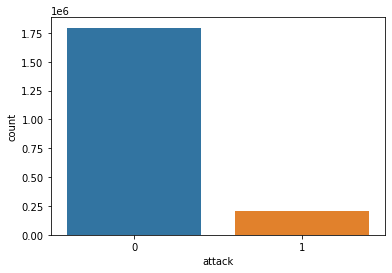

In [44]:
sns.countplot(x='attack', data=df_memory.toPandas())

<AxesSubplot:xlabel='attack', ylabel='count'>

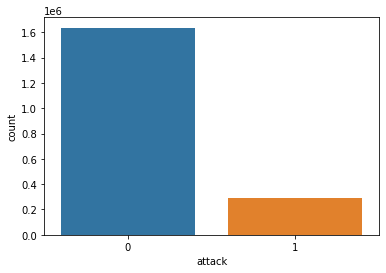

In [45]:
sns.countplot(x='attack', data=df_process.toPandas())

## As we can see from the plot above, we have so many 0 (not attacks) compared to 1 (attacks). Class imbalance arises for this kind of imbalance in the target variable.

<AxesSubplot:>

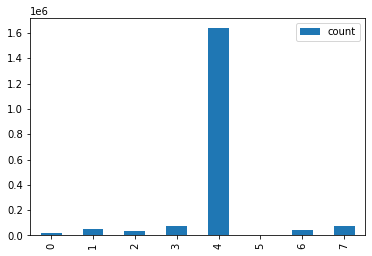

In [46]:
plot1.toPandas().plot(kind='bar')

In [47]:
#2. For each numeric feature in each activity, show the basic statistics (including count,
#mean, stddev, min, max); for each non-numeric feature in each activity, display the
#top-10 values and the corresponding counts.
#○ No need to show the labels at “attack” or “type” column

In [48]:
df_memory.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: float (nullable = true)
 |-- MAJFLT: float (nullable = true)
 |-- VSTEXT: float (nullable = true)
 |-- VSIZE: float (nullable = true)
 |-- RSIZE: float (nullable = true)
 |-- VGROW: float (nullable = true)
 |-- RGROW: float (nullable = true)
 |-- MEM: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [49]:
df_process.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [50]:
#pandas dataframe

df_memory.toPandas().describe()

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,attack
count,2000000.000,2000000.000,2000000.000,2000000.000,2000000.000,2000000.000,2000000.000,2000000.000,2000000.000,2000000.000,2000000.000
mean,1556245817.076,4999.360,983.344,987846.438,46453.258,4496.419,23722.881,984.467,483.175,0.003,0.103
std,984463.368,4887.313,19229.611,14842875.000,658730.250,9046.338,1986383.125,86174.828,1491.476,0.011,0.304
min,1554216855.000,1007.000,0.000,0.000,0.000,0.000,-9728.000,-9392000.000,0.000,0.000,0.000
25%,1555467883.750,2242.000,0.000,0.000,25.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1556443976.500,2847.000,10.000,0.000,148.000,0.000,98.200,0.000,0.000,0.000,0.000
75%,1556859200.000,4374.000,132.000,173.900,2132.000,732.300,2608.000,0.000,0.000,0.000,0.000
max,1558355716.000,53096.000,8050000.000,224400000.000,11200000.000,88040.000,224400000.000,11160000.000,98920.000,0.440,1.000


In [51]:
df_process.toPandas().describe()

,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU,attack
count,1927968.000,1927968.000,1927968.000,1927968.000,1927968.000,1927968.000,1927968.000,1927968.000,1927968.000,1927968.000,1927968.000,1927968.000
mean,1556319831.184,5068.710,0.063,3.508,0.000,-4.598,111.268,0.000,1.921,0.030,0.022,0.151
std,771350.025,4987.784,0.248,6.988,0.044,8.423,22.624,0.000,1.527,1.462,0.136,0.358
min,1554216855.000,1007.000,0.000,0.000,0.000,-20.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1556191875.750,2501.000,0.000,1.000,0.000,0.000,100.000,0.000,1.000,0.000,0.000,0.000
50%,1556497560.500,3103.000,0.000,1.000,0.000,0.000,120.000,0.000,2.000,0.000,0.000,0.000
75%,1556795835.250,4374.000,0.000,3.000,0.000,0.000,120.000,0.000,3.000,0.000,0.010,0.000
max,1557593017.000,53080.000,12.000,70.000,21.000,19.000,139.000,0.000,5.000,127.000,4.020,1.000


In [52]:
# counts of top ten CMD in memory
df_memory.select(col('CMD')).groupBy('CMD').count().sort(col("count").desc()).show(10)


+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



In [53]:
# counts of top ten type in memory
df_memory.select(col('type')).groupBy('type').count().sort(col("count").desc()).show(10)

+---------+-------+
|     type|  count|
+---------+-------+
|   normal|1794377|
|      dos|  75283|
|injection|  58523|
|     ddos|  45689|
| password|  26016|
|     mitm|    112|
+---------+-------+



In [54]:
# counts of top ten POLI in process
df_process.select(col('POLI')).groupBy('POLI').count().sort(col("count").desc()).show(10)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+



In [55]:
# counts of top ten Status in process
df_process.select(col('Status')).groupBy('Status').count().sort(col("count").desc()).show(10)

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+



In [56]:
# counts of top ten State in process
df_process.select(col('State')).groupBy('State').count().sort(col("count").desc()).show(10)

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+



In [57]:
# counts of top ten CMD in process
df_process.select(col('CMD')).groupBy('CMD').count().sort(col("count").desc()).show(10)

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



In [58]:
# counts of top ten type in process
df_process.select(col('type')).groupBy('type').count().sort(col("count").desc()).show(10)

+---------+-------+
|     type|  count|
+---------+-------+
|   normal|1636604|
|     ddos|  71603|
|      dos|  70721|
| password|  51409|
|injection|  41311|
| scanning|  38449|
|      xss|  17759|
|     mitm|    112|
+---------+-------+



    ##3. For each activity, present two plots3 worthy of presenting to the StopHacking
    #company, describe your plots and discuss the findings from the plots
    #○ Hint - 1: you can use the basic plots (e.g. histograms, line charts, scatter
    #plots) for relationship between a column and the “attack” label (such as “ts”
    #and “attack”, “PID” and “attack”); or more advanced plots like correlation plots
    #for relationship between each column; 2: if your data is too large for the
    #plotting, consider using sampling before plotting
    #○ 100 words max for each plot’s description and discussion

In [59]:
# converting to a pandas dataframe
df_mem = df_memory.toPandas()

In [60]:
df_mem = df_mem[['ts','PID','MINFLT','MAJFLT','VSTEXT','VSIZE','RSIZE','VGROW','RGROW','MEM','attack']]

## Correlation matrix

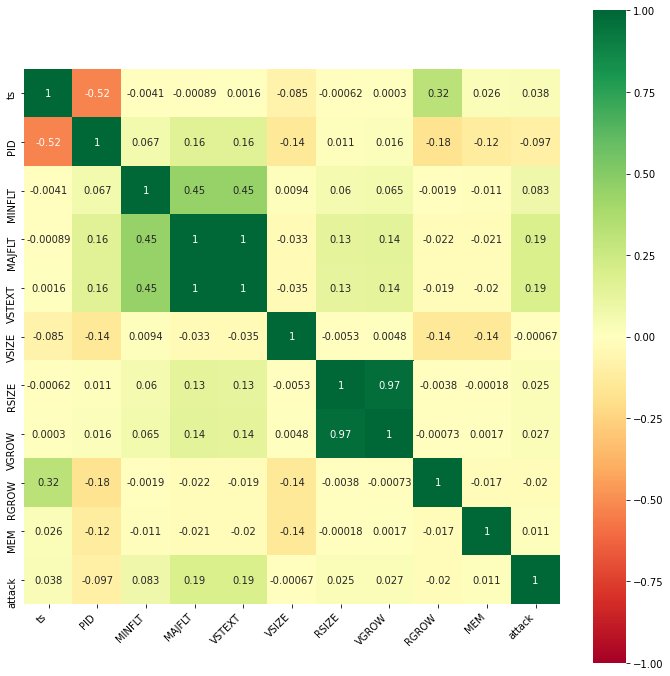

In [61]:
fig, ax = plt.subplots(figsize=(12,12))
corr = df_mem.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap="RdYlGn",
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Histograms of all the numeric variables in the memory data

array([[<AxesSubplot:title={'center':'MAJFLT'}>,
        <AxesSubplot:title={'center':'MEM'}>,
        <AxesSubplot:title={'center':'MINFLT'}>],
       [<AxesSubplot:title={'center':'PID'}>,
        <AxesSubplot:title={'center':'RGROW'}>,
        <AxesSubplot:title={'center':'RSIZE'}>],
       [<AxesSubplot:title={'center':'VGROW'}>,
        <AxesSubplot:title={'center':'VSIZE'}>,
        <AxesSubplot:title={'center':'VSTEXT'}>],
       [<AxesSubplot:title={'center':'attack'}>,
        <AxesSubplot:title={'center':'ts'}>, <AxesSubplot:>]],
      dtype=object)

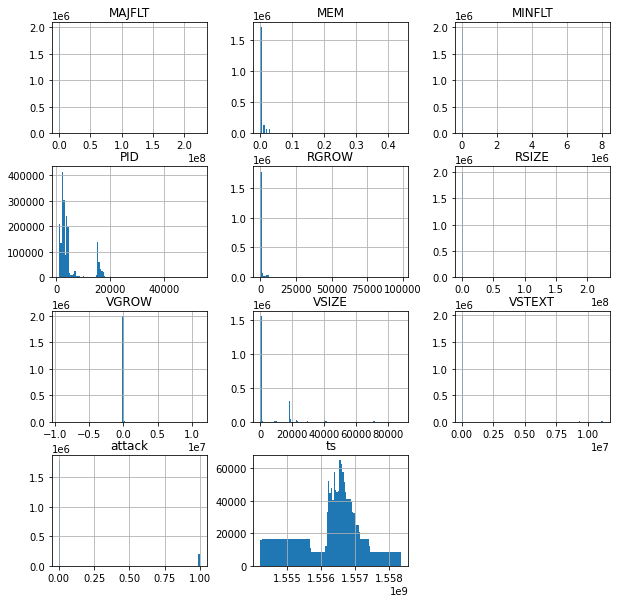

In [62]:

df_mem.hist(bins = 100, figsize = (10,10))



In [63]:
# converting to a pandas dataframe
df_proc = df_process.toPandas()

In [64]:
df_proc = df_proc[['ts','PID', 'TRUN','TSLPI','TSLPU','NICE','PRI','RTPR','CPUNR','EXC','CPU','attack']]

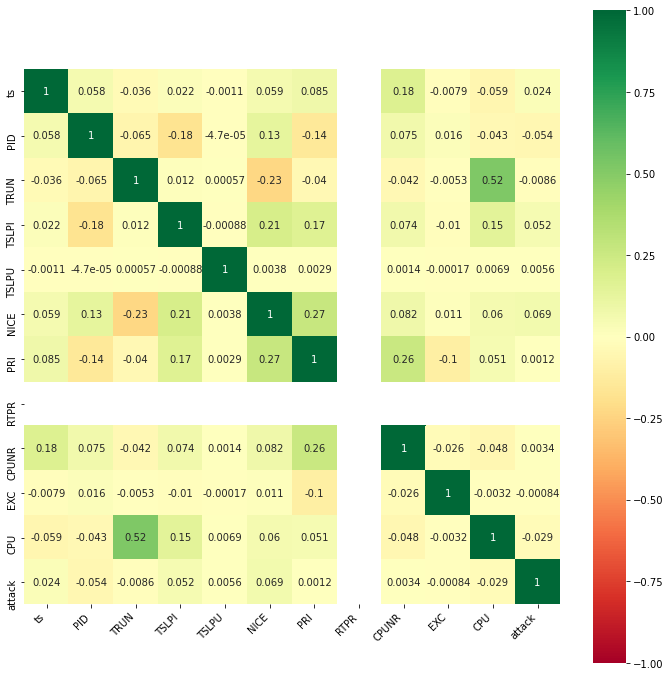

In [65]:
fig, ax = plt.subplots(figsize=(12,12))
corr = df_proc.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap="RdYlGn",
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Histograms of all the numeric variables in the process data

array([[<AxesSubplot:title={'center':'CPU'}>,
        <AxesSubplot:title={'center':'CPUNR'}>,
        <AxesSubplot:title={'center':'EXC'}>],
       [<AxesSubplot:title={'center':'NICE'}>,
        <AxesSubplot:title={'center':'PID'}>,
        <AxesSubplot:title={'center':'PRI'}>],
       [<AxesSubplot:title={'center':'RTPR'}>,
        <AxesSubplot:title={'center':'TRUN'}>,
        <AxesSubplot:title={'center':'TSLPI'}>],
       [<AxesSubplot:title={'center':'TSLPU'}>,
        <AxesSubplot:title={'center':'attack'}>,
        <AxesSubplot:title={'center':'ts'}>]], dtype=object)

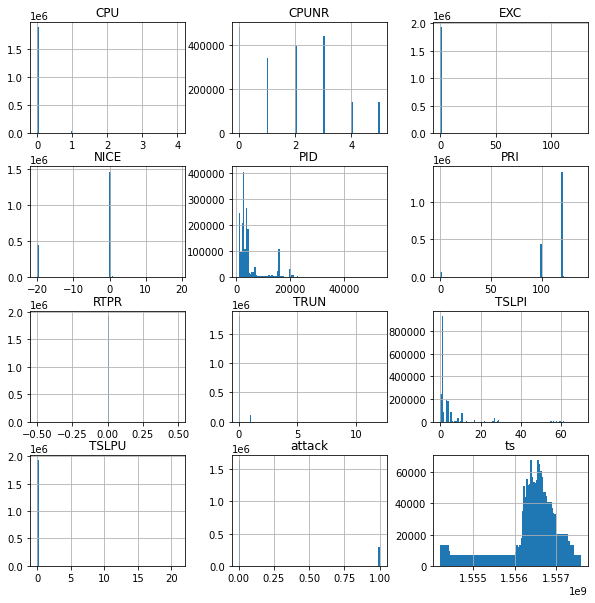

In [66]:
df_proc.hist(bins = 100, figsize = (10,10))

In [67]:
# vis of period in timestamp where attacks are hapenning

<AxesSubplot:xlabel='attack', ylabel='ts'>

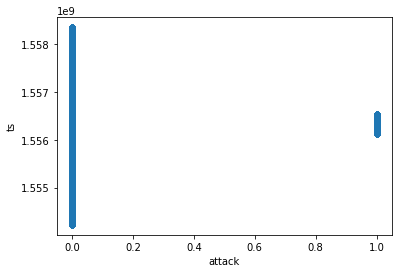

In [68]:
zz = df_memory.select('ts', 'attack')

zz.toPandas().plot.scatter(x= 'attack', y = 'ts')



<AxesSubplot:xlabel='ts', ylabel='attack'>

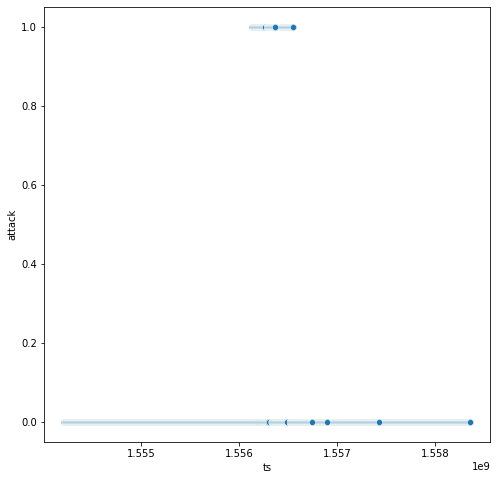

In [69]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=df_memory.toPandas(), x="ts", y="attack")

<AxesSubplot:xlabel='ts', ylabel='attack'>

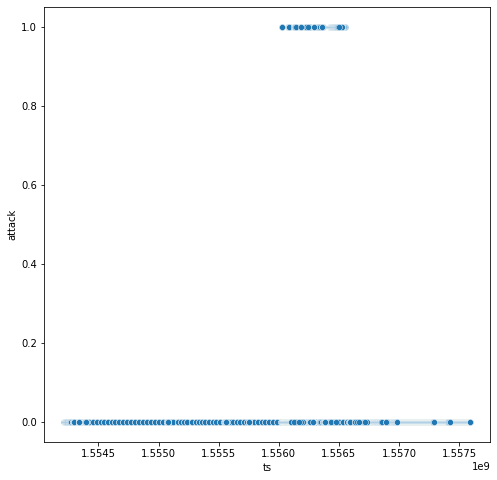

In [70]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=df_process.toPandas(), x="ts", y="attack")

In [71]:
kk = df_memory.filter(df_memory['attack']==1).select('MAJFLT', 'attack')\
.groupBy('MAJFLT','attack').agg(count('attack')).sort(col("count(attack)").desc())


kk = kk.toPandas().head(10)

<AxesSubplot:xlabel='MAJFLT', ylabel='count(attack)'>

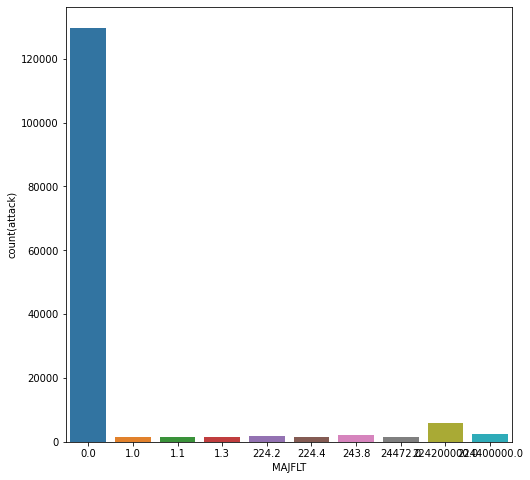

In [72]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(data=kk, x="MAJFLT", y="count(attack)")

<AxesSubplot:xlabel='CMD', ylabel='count(attack)'>

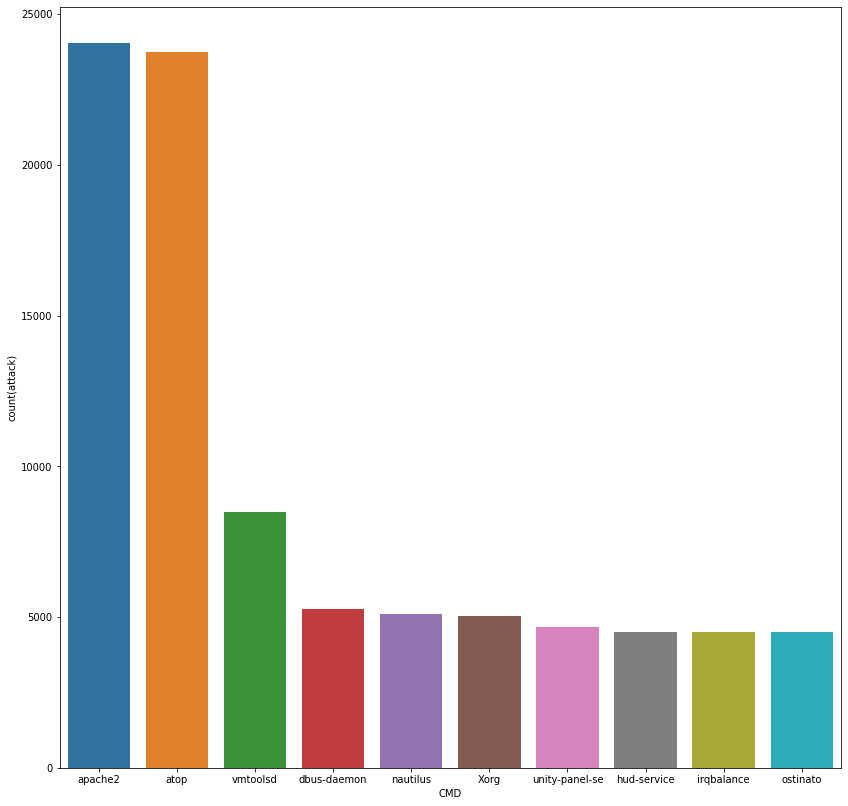

In [73]:
kg = df_memory.filter(df_memory['attack']==1).select('CMD', 'attack')\
.groupBy('CMD').agg(count('attack')).sort(col("count(attack)").desc())


kg = kg.toPandas().head(10)

fig, ax = plt.subplots(figsize=(14,14))

sns.barplot(data=kg, x="CMD", y="count(attack)")

<AxesSubplot:xlabel='CMD', ylabel='count(attack)'>

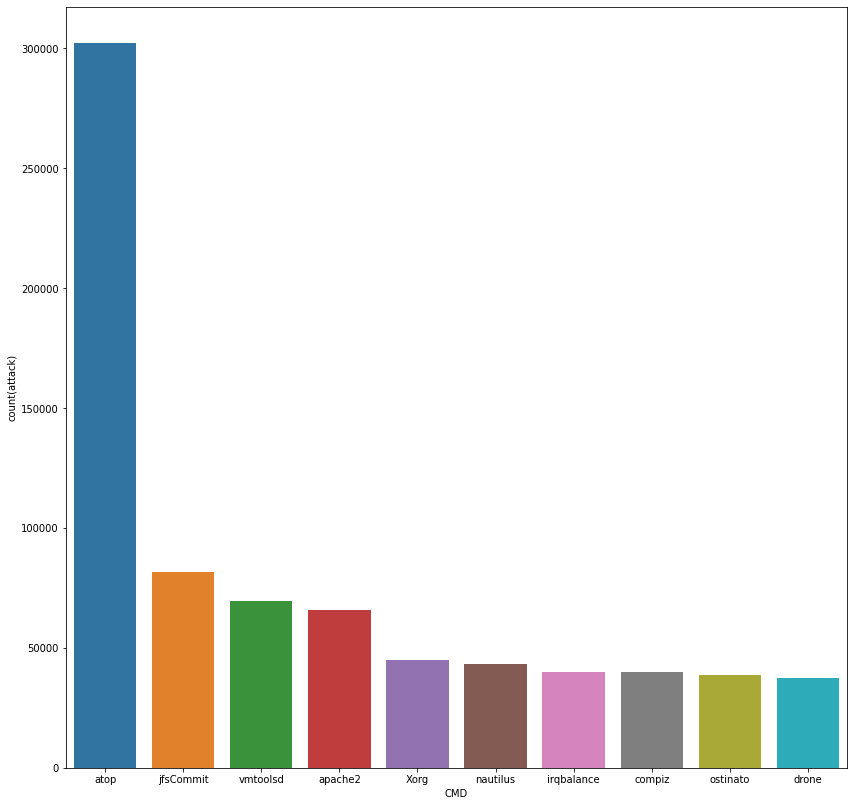

In [74]:
kg = df_memory.filter(df_memory['attack']==0).select('CMD', 'attack')\
.groupBy('CMD').agg(count('attack')).sort(col("count(attack)").desc())


kg = kg.toPandas().head(10)

fig, ax = plt.subplots(figsize=(14,14))

sns.barplot(data=kg, x="CMD", y="count(attack)")

## Some visualisaitons using the timestamp data - for pyspark dataframe

## For memory data

In [75]:
table = df_memory

# Import the libraries
from pyspark.sql.functions import udf
from datetime import datetime

# Create a function that returns the desired string from a timestamp 
def format_timestamp(tss):
    return datetime.fromtimestamp(tss).strftime('%Y-%m-%d %H:%M:%S')

# Create the UDF
format_timestamp_udf = udf(lambda x: format_timestamp(x))

# Finally, apply the function to each element of the 'timestamp' column
table = table.withColumn('ts', format_timestamp_udf(table['ts']))

table.show()

+-------------------+-----+------+------+-------+-------+-------+-----+-----+----+--------------+------+------+
|                 ts|  PID|MINFLT|MAJFLT| VSTEXT|  VSIZE|  RSIZE|VGROW|RGROW| MEM|           CMD|attack|  type|
+-------------------+-----+------+------+-------+-------+-------+-----+-----+----+--------------+------+------+
|2019-05-02 06:44:08| 2123|   9.0|   0.0|  596.0|  191.7| 4712.0|  0.0|  0.0| 0.0|       apache2|     0|normal|
|2019-05-02 06:44:13| 2925|   0.0|   0.0|  350.0|  315.3| 4596.0|  0.0|  0.0| 0.0|mission-contro|     0|normal|
|2019-05-02 06:44:18| 1192|   2.0|   0.0| 1071.0|  342.1| 4528.0|  0.0|  0.0| 0.0|NetworkManager|     0|normal|
|2019-05-02 06:44:23| 1404|   0.0|   0.0|   47.0|  505.2| 3584.0|  0.0|  0.0| 0.0|      whoopsie|     0|normal|
|2019-05-02 06:44:28| 3238|   0.0|   0.0|   18.0|  368.9| 3516.0|  0.0|  0.0| 0.0|deja-dup-monit|     0|normal|
|2019-05-02 06:44:33| 3897|1928.0|   0.0|  148.0|17944.0| 2604.0|  0.0|  0.0| 0.0|          atop|     0|

In [76]:
from pyspark.sql.functions import substring

table = table.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID','MINFLT','MAJFLT','VSTEXT',\
                     'VSIZE','RSIZE','VGROW','RGROW','MEM','attack','CMD', 'type')

table.show(5)

+-------------------+----+-----+---+----+----+------+------+------+-----+------+-----+-----+---+------+--------------+------+
|                 ts|year|month|day|hour| PID|MINFLT|MAJFLT|VSTEXT|VSIZE| RSIZE|VGROW|RGROW|MEM|attack|           CMD|  type|
+-------------------+----+-----+---+----+----+------+------+------+-----+------+-----+-----+---+------+--------------+------+
|2019-05-02 06:44:08|2019|   05| 02|  06|2123|   9.0|   0.0| 596.0|191.7|4712.0|  0.0|  0.0|0.0|     0|       apache2|normal|
|2019-05-02 06:44:13|2019|   05| 02|  06|2925|   0.0|   0.0| 350.0|315.3|4596.0|  0.0|  0.0|0.0|     0|mission-contro|normal|
|2019-05-02 06:44:18|2019|   05| 02|  06|1192|   2.0|   0.0|1071.0|342.1|4528.0|  0.0|  0.0|0.0|     0|NetworkManager|normal|
|2019-05-02 06:44:23|2019|   05| 02|  06|1404|   0.0|   0.0|  47.0|505.2|3584.0|  0.0|  0.0|0.0|     0|      whoopsie|normal|
|2019-05-02 06:44:28|2019|   05| 02|  06|3238|   0.0|   0.0|  18.0|368.9|3516.0|  0.0|  0.0|0.0|     0|deja-dup-monit|

<AxesSubplot:xlabel='day', ylabel='count(attack)'>

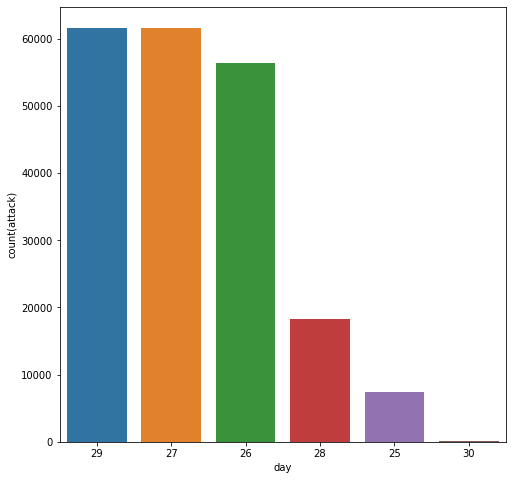

In [77]:
# showing the days in the month when the most sttacks happended

kkk = table.filter(table['attack']==1).select('day', 'attack')\
.groupBy('day','attack').agg(count('attack')).sort(col("count(attack)").desc())


kkk = kkk.toPandas()

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(data=kkk, x="day", y="count(attack)")


## We can se here that attacks happen in only a few days, and most attacks happened on days 26,27,28,29 of the month. day can be used as a feature for the the ML model.

<AxesSubplot:xlabel='count(attack)', ylabel='hour'>

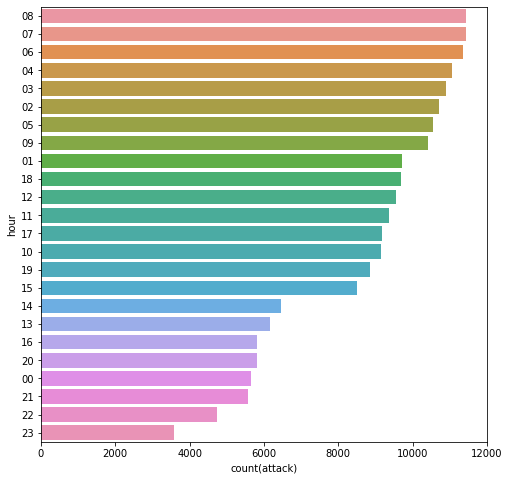

In [78]:
#showing which hours of the day had the most attacks

kkk = table.filter(table['attack']==1).select('hour', 'attack')\
.groupBy('hour','attack').agg(count('attack')).sort(col("count(attack)").desc())


kkk = kkk.toPandas()

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(data=kkk, x="count(attack)", y="hour", orient = 'h')

## There is also some variation in hour of the day when attacks happen.

## For process data

In [79]:
table2 = df_process


# Import the libraries
from pyspark.sql.functions import udf
from datetime import datetime

# Create a function that returns the desired string from a timestamp 
def format_timestamp(tss):
    return datetime.fromtimestamp(tss).strftime('%Y-%m-%d %H:%M:%S')

# Create the UDF
format_timestamp_udf = udf(lambda x: format_timestamp(x))

# Finally, apply the function to each element of the 'timestamp' column
table2 = table2.withColumn('ts', format_timestamp_udf(table2['ts']))

table2 = table2.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID', 'TRUN','TSLPI','TSLPU','NICE',\
                       'PRI','RTPR','CPUNR','EXC','CPU','attack','Status', 'State', 'CMD', 'type')

<AxesSubplot:xlabel='day', ylabel='count(attack)'>

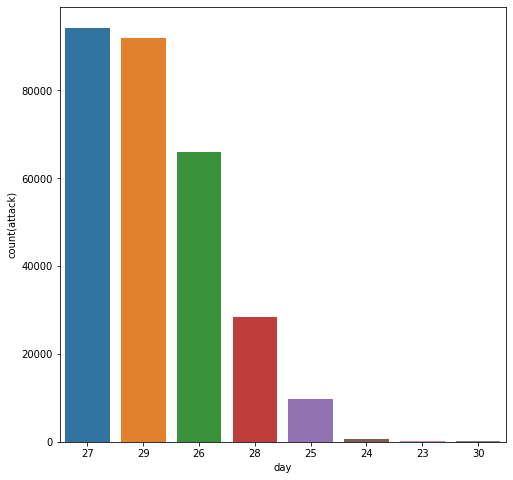

In [80]:
# showing the days in the month when the most sttacks happended

kkkk = table2.filter(table2['attack']==1).select('day', 'attack')\
.groupBy('day','attack').agg(count('attack')).sort(col("count(attack)").desc())


kkkk = kkkk.toPandas()

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(data=kkkk, x="day", y="count(attack)")

<AxesSubplot:xlabel='count(attack)', ylabel='hour'>

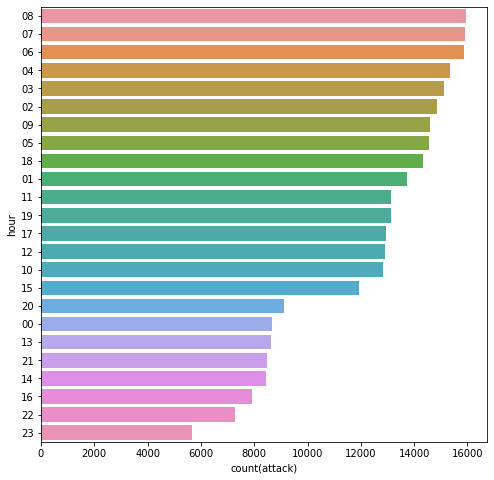

In [81]:
#showing which hours of the day had the most attacks

kkkk = table2.filter(table2['attack']==1).select('hour', 'attack')\
.groupBy('hour','attack').agg(count('attack')).sort(col("count(attack)").desc())


kkkk = kkkk.toPandas()

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(data=kkkk, x="count(attack)", y="hour", orient = 'h')

# 2. Feature extraction and ML training (55%)

## 2.1 Preparing the training data and testing data (4%)

In [82]:
#1. Randomly split the dataset into 80% training data and 20% testing data for each use case

In [83]:
#Write your code here

train_mem, test_mem = df_memory.randomSplit([0.8, 0.2], seed=12345)
train_mem.toPandas()

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,attack,type
0,1554216855,12189,132.000,2820.000,1236.000,0.000,2820.000,1236.000,0.000,0.000,mkinitramfs,0,normal
1,1554216860,10000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,<modinfo>,0,normal
2,1554216865,10001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,<mkdir>,0,normal
3,1554216870,10002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,<cp>,0,normal
4,1554216875,10003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,<modinfo>,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600300,1557422465,2842,0.000,0.000,350.000,315.300,2076.000,0.000,0.000,0.000,mission-contro,0,normal
1600301,1557422470,2420,0.000,0.000,415.000,40212.000,1956.000,0.000,0.000,0.000,dbus-daemon,0,normal
1600302,1557422475,1851,0.000,0.000,36.000,159.800,1704.000,0.000,0.000,0.000,vmtoolsd,0,normal
1600303,1557422480,3311,0.000,0.000,18.000,441.100,1264.000,0.000,0.000,0.000,deja-dup-monit,0,normal


In [84]:
test_mem.toPandas()

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,attack,type
0,1554216885,10005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,<cp>,0,normal
1,1554216975,10023,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,<cp>,0,normal
2,1554216980,10024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,<modinfo>,0,normal
3,1554217000,10028,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,<mkdir>,0,normal
4,1554217035,10035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,<cp>,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399690,1557422320,4373,1945.000,0.000,148.000,17968.000,2560.000,0.000,0.000,0.000,atop,0,normal
399691,1557422435,4373,1945.000,0.000,148.000,17972.000,2560.000,0.000,0.000,0.000,atop,0,normal
399692,1557422445,2788,0.000,0.000,4.000,857.600,2452.000,0.000,0.000,0.000,evolution-cale,0,normal
399693,1557422450,4375,1945.000,0.000,148.000,17640.000,2452.000,0.000,0.000,0.000,atop,0,normal


In [85]:
train_proc, test_proc = df_process.randomSplit([0.8, 0.2], seed=12345)
train_proc.toPandas()

,ts,PID,TRUN,TSLPI,TSLPU,POLI,NICE,PRI,RTPR,CPUNR,Status,EXC,State,CPU,CMD,attack,type
0,1554216855,11115,0,0,0,0,0,0,0,0,NE,0,E,0.030,<mkinitramfs>,0,normal
1,1554216860,10566,0,0,0,0,0,0,0,0,NE,0,E,0.000,<mkinitramfs>,0,normal
2,1554216865,10862,0,0,0,0,0,0,0,0,NE,0,E,0.000,<mkinitramfs>,0,normal
3,1554216870,11564,0,0,0,0,0,0,0,0,NE,0,E,0.000,<cp>,0,normal
4,1554216875,11572,0,0,0,0,0,0,0,0,NE,0,E,0.000,<cp>,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542838,1556739888,2978,0,3,0,norm,0,120,0,0,-,0,S,0.000,vmtoolsd,0,normal
1542839,1556739893,2122,0,1,0,norm,0,120,0,3,-,0,S,0.000,apache2,0,normal
1542840,1556739908,2118,0,1,0,norm,0,120,0,3,-,0,S,0.000,apache2,0,normal
1542841,1556739913,2121,0,1,0,norm,0,120,0,0,-,0,S,0.000,apache2,0,normal


In [86]:
test_proc.toPandas()

,ts,PID,TRUN,TSLPI,TSLPU,POLI,NICE,PRI,RTPR,CPUNR,Status,EXC,State,CPU,CMD,attack,type
0,1554216885,11617,0,0,0,0,0,0,0,0,NE,0,E,0.000,<cp>,0,normal
1,1554216975,10001,0,0,0,0,0,0,0,0,NE,0,E,0.000,<mkdir>,0,normal
2,1554216980,10002,0,0,0,0,0,0,0,0,NE,0,E,0.000,<cp>,0,normal
3,1554217000,10006,0,0,0,0,0,0,0,0,NE,0,E,0.000,<modinfo>,0,normal
4,1554217035,10013,0,0,0,0,0,0,0,0,NE,0,E,0.000,<mkdir>,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385120,1556739873,2433,0,1,0,norm,0,120,0,0,-,0,S,0.000,dbus-daemon,0,normal
385121,1556739883,2119,0,1,0,norm,0,120,0,0,-,0,S,0.000,apache2,0,normal
385122,1556739898,5843,0,1,0,norm,0,120,0,3,-,0,S,0.000,apache2,0,normal
385123,1556739903,4075,0,1,0,norm,0,120,0,3,-,0,S,0.000,apache2,0,normal


In [87]:
# 2. With the class imbalance observed from 1.3.1, for the binary classification use case 1
#& 2, prepare rebalanced training data, with attack events and non-attack events
#being 1:2 ratio, while using 20% attack events data from the training data from 2.1.1.
#Cache the rebalanced training data, and display the count of each event's data.
#○ Hint - you can use undersampling to get the rebalanced training data

## For memory case

### Training data

In [88]:

# Separate 0 and 1 classes
train_mem_0 = train_mem[train_mem.attack==0]
train_mem_1 = train_mem[train_mem.attack==1]

# counts of separate classes
count_0 = train_mem_0.count()
count_1 = train_mem_1.count()

# ratio of 0 class
train_mem_0_ratio = (count_1*2/count_0)*0.2


#undersampling
train_mem_1 = train_mem_1.sample(False, 0.2, 12345)
train_mem_0 = train_mem_0.sample(False, train_mem_0_ratio, 12345)

# merging the dataframes
train_mem_downsampled = train_mem_1.union(train_mem_0)




In [89]:
train_mem_downsampled.groupBy('attack').agg(count('attack')).show()

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|        32781|
|     0|        65842|
+------+-------------+



### Testing data

In [90]:
# Separate 0 and 1 classes
test_mem_0 = test_mem[test_mem.attack==0]
test_mem_1 = test_mem[test_mem.attack==1]

# counts of separate classes
count_0 = test_mem_0.count()
count_1 = test_mem_1.count()

# ratio of 0 class
test_mem_0_ratio = (count_1*2/count_0)*0.2


#undersampling
test_mem_1 = test_mem_1.sample(False, 0.2, 12345)
test_mem_0 = test_mem_0.sample(False, test_mem_0_ratio, 12345)

# merging the dataframes
test_mem_downsampled = test_mem_1.union(test_mem_0)

In [91]:
test_mem_downsampled.groupBy('attack').agg(count('attack')).show()

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|         8273|
|     0|        16394|
+------+-------------+



## For process case

### Training data

In [92]:
# Separate 0 and 1 classes
train_proc_0 = train_proc[train_proc.attack==0]
train_proc_1 = train_proc[train_proc.attack==1]

# counts of separate classes
count_0 = train_proc_0.count()
count_1 = train_proc_1.count()

# ratio of 0 class
train_proc_0_ratio = (count_1*2/count_0)*0.2


#undersampling
train_proc_1 = train_proc_1.sample(False, 0.2, 12345)
train_proc_0 = train_proc_0.sample(False, train_proc_0_ratio, 12345)

# merging the dataframes
train_proc_downsampled = train_proc_1.union(train_proc_0)


In [93]:
train_proc_downsampled.groupBy('attack').agg(count('attack')).show()

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|        46789|
|     0|        93454|
+------+-------------+



### Testing data

In [94]:
# Separate 0 and 1 classes
test_proc_0 = test_proc[test_proc.attack==0]
test_proc_1 = test_proc[test_proc.attack==1]

# counts of separate classes
count_0 = test_proc_0.count()
count_1 = test_proc_1.count()

# ratio of 0 class
test_proc_0_ratio = (count_1*2/count_0)*0.2


#undersampling
test_proc_1 = test_proc_1.sample(False, 0.2, 12345)
test_proc_0 = test_proc_0.sample(False, test_proc_0_ratio, 12345)

# merging the dataframes
test_proc_downsampled = test_proc_1.union(test_proc_0)


In [95]:
test_proc_downsampled.groupBy('attack').agg(count('attack')).show()

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|        11724|
|     0|        23238|
+------+-------------+



## 2.2 Preparing features, labels and models (16%)

## Create Transformers / Estimators for transforming / assembling the features

## FOR process

### Converting timestamp column to datetime to extract day and hour variables for the model

In [96]:
train_proc_table = train_proc_downsampled

# Import the libraries
from pyspark.sql.functions import udf
from datetime import datetime

# Create a function that returns the desired string from a timestamp 
def format_timestamp(tss):
    return datetime.fromtimestamp(tss).strftime('%Y-%m-%d %H:%M:%S')

# Create the UDF
format_timestamp_udf = udf(lambda x: format_timestamp(x))

# Finally, apply the function to each element of the 'timestamp' column
train_proc_table = train_proc_table.withColumn('ts', format_timestamp_udf(train_proc_table['ts']))

train_proc_table = train_proc_table.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID','TRUN','TSLPI','TSLPU',\
                     'POLI','NICE','PRI','RTPR','CPUNR','Status','EXC', 'State', 'CPU', 'CMD', 'attack', 'type')






test_proc_table = test_proc

# Finally, apply the function to each element of the 'timestamp' column
test_proc_table = test_proc_table.withColumn('ts', format_timestamp_udf(test_proc_table['ts']))

test_proc_table = test_proc_table.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID','TRUN','TSLPI','TSLPU',\
                     'POLI','NICE','PRI','RTPR','CPUNR','Status','EXC', 'State', 'CPU', 'CMD', 'attack', 'type')


train_proc_table = train_proc_table.withColumn("day", train_proc_table["day"].cast(IntegerType()))
train_proc_table = train_proc_table.withColumn("hour", train_proc_table["hour"].cast(IntegerType()))
train_proc_table = train_proc_table.withColumn("month", train_proc_table["month"].cast(IntegerType()))


test_proc_table = test_proc_table.withColumn("day", test_proc_table["day"].cast(IntegerType()))
test_proc_table = test_proc_table.withColumn("hour", test_proc_table["hour"].cast(IntegerType()))
test_proc_table = test_proc_table.withColumn("month", test_proc_table["month"].cast(IntegerType()))

## Feature selection and importance


<AxesSubplot:>

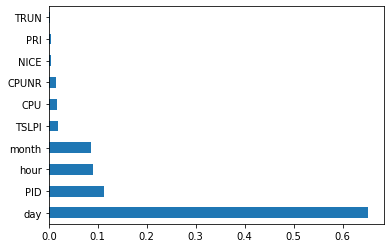

In [97]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline            

X = train_proc_table

k = ['ts','year','POLI','Status','State','CMD','type']

X = X.select([column for column in X.columns if column not in k]).toPandas()
y = X.pop('attack')

model = RandomForestClassifier()
model.fit(X, y)

(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))  

### BUILDING MODEL (DECISION TREE) - String indexing, Vector assembling and decision tree classifier model for the process use case

In [98]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col


#string Indexer



proc_columns = [ 'CMD', 'State', 'Status', 'POLI']


from pyspark.ml.feature import StringIndexer

inputCols = [col for col in proc_columns ]
outputCols = [f"{col}_idx" for col in proc_columns]




stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols).setHandleInvalid("keep")




from pyspark.ml.feature import VectorAssembler

inputCols_VA = outputCols

for i in ['PID','day', 'hour','month',]:
    inputCols_VA.append(i)
    

stage_2 = VectorAssembler(inputCols=(inputCols_VA),outputCol="features")


# Train a DecisionTree model.
decision_tree = DecisionTreeClassifier(labelCol='attack', featuresCol = 'features',impurity='gini', maxBins = 100000)

## 2.3 Training and evaluating models

### Stages for the pipeline

In [99]:
# Chain indexers and tree in a Pipeline
pipeline =  Pipeline(stages=[stage_1,stage_2,decision_tree])

# Train model.  This also runs the indexers.
model = pipeline.fit(train_proc_table)

# Make predictions.
predictions =  model.transform(test_proc_table)

# Select example rows to display.
selection = predictions.select("features","probability", "attack", "prediction")
selection.show(truncate=False)

+--------------------------------------+-----------+------+----------+
|features                              |probability|attack|prediction|
+--------------------------------------+-----------+------+----------+
|[75.0,3.0,2.0,1.0,11617.0,3.0,1.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[67.0,3.0,2.0,1.0,10001.0,3.0,1.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[75.0,3.0,2.0,1.0,10002.0,3.0,1.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[80.0,3.0,2.0,1.0,10006.0,3.0,1.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[67.0,3.0,2.0,1.0,10013.0,3.0,1.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[80.0,3.0,2.0,1.0,10024.0,3.0,1.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[80.0,3.0,2.0,1.0,10027.0,3.0,1.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[75.0,3.0,2.0,1.0,10044.0,3.0,1.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[80.0,3.0,2.0,1.0,10069.0,3.0,2.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[80.0,3.0,2.0,1.0,10072.0,3.0,2.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[80.0,3.0,2.0,1.0,10075.0,3.0,2.0,4.0]|[1.0,0.0]  |0     |0.0       |
|[75.0

## Model Metrics

In [100]:
# Calculating the elements for the confusion matrix
True_Negative = predictions.filter('prediction = 0.0 AND attack = 0').count()
True_Positive = predictions.filter('prediction = 1.0 AND attack = 1').count()
False_Negative = predictions.filter('prediction = 0.0 AND attack = 1').count()
False_Positive = predictions.filter('prediction = 1.0 AND attack = 0').count()

# showing the confusion matrix
predictions.groupBy('attack', 'prediction').count().show()
# calculate metrics by the confusion matrix
accuracy = (True_Positive+True_Negative)/(True_Positive+True_Negative+False_Positive+False_Negative)
precision = True_Positive/(True_Positive+False_Positive)
recall = True_Positive/(True_Positive+False_Negative)
f1 = 2/((1/recall)+(1/precision))

#Printing out the various metrics calculated above
print("Accuracy for the model is: ",accuracy)
print("Precision for the model is: ",precision)
print("Recall for the model is: ",recall)
print("F1 score for the model is: ",f1)

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  6554|
|     0|       0.0|297863|
|     1|       1.0| 51470|
|     0|       1.0| 29238|
+------+----------+------+

Accuracy for the model is:  0.9070639402791302
Precision for the model is:  0.6377310799425088
Recall for the model is:  0.8870467392802978
F1 score for the model is:  0.7420061701698238


In [101]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(labelCol="attack", rawPredictionCol="prediction", metricName = 'areaUnderROC')
auc_dt = evaluator.evaluate(predictions)
print(auc_dt)
print(evaluator.getMetricName())

0.8988307517637131
areaUnderROC


### top-5 most important features in model

In [102]:
## Reference - https://kb.databricks.com/machine-learning/extract-feature-info.html?fbclid=IwAR1fuedxIqlif4oz150ERk3iP09IfSwGYacl3HVnUooMQhbxXGf537IasCk

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stage_1, stage_2, decision_tree])
DTmodel = pipeline.fit(train_proc_table)
va = DTmodel.stages[-2]
tree = DTmodel.stages[-1]

display(tree) #visualize the decision tree model
print(tree.toDebugString) #print the nodes of the decision tree model

d_list = list(zip(va.getInputCols(), tree.featureImportances))

sorted(d_list,key=lambda x:(-x[1],x[0]))[0:5]

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_39800cf5879b, depth=5, numNodes=33, numClasses=2, numFeatures=8

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_39800cf5879b, depth=5, numNodes=33, numClasses=2, numFeatures=8
  If (feature 5 <= 24.5)
   If (feature 5 <= 22.5)
    Predict: 0.0
   Else (feature 5 > 22.5)
    If (feature 6 <= 12.5)
     If (feature 6 <= 0.5)
      If (feature 1 in {0.0})
       Predict: 0.0
      Else (feature 1 not in {0.0})
       Predict: 1.0
     Else (feature 6 > 0.5)
      Predict: 0.0
    Else (feature 6 > 12.5)
     If (feature 6 <= 16.5)
      Predict: 0.0
     Else (feature 6 > 16.5)
      If (feature 2 in {2.0,3.0,4.0})
       Predict: 1.0
      Else (feature 2 not in {2.0,3.0,4.0})
       Predict: 0.0
  Else (feature 5 > 24.5)
   If (feature 5 <= 29.5)
    If (feature 5 <= 25.5)
     If (feature 6 <= 19.5)
      If (feature 6 <= 15.5)
       Predict: 0.0
      Else (feature 6 > 15.5)
       Predict: 1.0
     Else (feature 6 > 19.5)
      Predict: 0.0
    Else (feature 5 > 25.5)
     If (feature 5 <= 27.5)
      Predict: 1.0
     Else (feature 

[('day', 0.9831749129735269),
 ('hour', 0.016314347722173057),
 ('Status_idx', 0.00029536968221402873),
 ('State_idx', 0.00010743766976846193),
 ('CMD_idx', 7.042076784887452e-05)]

## 2.3 Training and evaluating models

## Gradient boosting model

In [103]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Train a Gradient boosting model.


gradient_boost = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10, maxBins = 100000)

# Chain indexers and tree in a Pipeline
pipeline =  Pipeline(stages=[stage_1,stage_2,gradient_boost])

# Train model.  This also runs the indexers.
model = pipeline.fit(train_proc_table)

# Make predictions.
predictions =  model.transform(test_proc_table)

# Select example rows to display.
selection = predictions.select("features","probability", "attack", "prediction")
selection.show(truncate=False)



+--------------------------------------+----------------------------------------+------+----------+
|features                              |probability                             |attack|prediction|
+--------------------------------------+----------------------------------------+------+----------+
|[75.0,3.0,2.0,1.0,11617.0,3.0,1.0,4.0]|[0.9341221756527823,0.06587782434721767]|0     |0.0       |
|[67.0,3.0,2.0,1.0,10001.0,3.0,1.0,4.0]|[0.9341221756527823,0.06587782434721767]|0     |0.0       |
|[75.0,3.0,2.0,1.0,10002.0,3.0,1.0,4.0]|[0.9341221756527823,0.06587782434721767]|0     |0.0       |
|[80.0,3.0,2.0,1.0,10006.0,3.0,1.0,4.0]|[0.9341221756527823,0.06587782434721767]|0     |0.0       |
|[67.0,3.0,2.0,1.0,10013.0,3.0,1.0,4.0]|[0.9341221756527823,0.06587782434721767]|0     |0.0       |
|[80.0,3.0,2.0,1.0,10024.0,3.0,1.0,4.0]|[0.9341221756527823,0.06587782434721767]|0     |0.0       |
|[80.0,3.0,2.0,1.0,10027.0,3.0,1.0,4.0]|[0.9341221756527823,0.06587782434721767]|0     |0.0       |


## Model Metrics

In [104]:
# Calculating the elements for the confusion matrix
True_Negative = predictions.filter('prediction = 0.0 AND attack = 0').count()
True_Positive = predictions.filter('prediction = 1.0 AND attack = 1').count()
False_Negative = predictions.filter('prediction = 0.0 AND attack = 1').count()
False_Positive = predictions.filter('prediction = 1.0 AND attack = 0').count()

# showing the confusion matrix
predictions.groupBy('attack', 'prediction').count().show()
# calculate metrics by the confusion matrix
accuracy = (True_Positive+True_Negative)/(True_Positive+True_Negative+False_Positive+False_Negative)
precision = True_Positive/(True_Positive+False_Positive)
recall = True_Positive/(True_Positive+False_Negative)
f1 = 2/((1/recall)+(1/precision))

#Printing out the various metrics calculated above
print("Accuracy for the model is: ",accuracy)
print("Precision for the model is: ",precision)
print("Recall for the model is: ",recall)
print("F1 score for the model is: ",f1)

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  3859|
|     0|       0.0|300644|
|     1|       1.0| 54165|
|     0|       1.0| 26457|
+------+----------+------+

Accuracy for the model is:  0.9212827004219409
Precision for the model is:  0.6718389521470567
Recall for the model is:  0.9334930373638495
F1 score for the model is:  0.7813424116094225


## AUC

In [105]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(labelCol="attack", rawPredictionCol="rawPrediction", metricName = 'areaUnderROC')
auc_gb = evaluator.evaluate(predictions)
print(evaluator.getMetricName())
print(auc_gb)


areaUnderROC
0.9771873478860985


### top-5 most important features in model

In [106]:
## Reference - https://kb.databricks.com/machine-learning/extract-feature-info.html?fbclid=IwAR1fuedxIqlif4oz150ERk3iP09IfSwGYacl3HVnUooMQhbxXGf537IasCk

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stage_1, stage_2, gradient_boost])
DTmodel = pipeline.fit(train_proc_table)
va = DTmodel.stages[-2]
tree = DTmodel.stages[-1]

display(tree) #visualize the decision tree model
print(tree.toDebugString) #print the nodes of the decision tree model

d_list = list(zip(va.getInputCols(), tree.featureImportances))

sorted(d_list,key=lambda x:(-x[1],x[0]))[0:5]

GBTClassificationModel: uid = GBTClassifier_889010a43ca7, numTrees=10, numClasses=2, numFeatures=8

GBTClassificationModel: uid = GBTClassifier_889010a43ca7, numTrees=10, numClasses=2, numFeatures=8
  Tree 0 (weight 1.0):
    If (feature 5 <= 24.5)
     If (feature 5 <= 22.5)
      Predict: -1.0
     Else (feature 5 > 22.5)
      If (feature 0 in {0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,17.0,18.0,19.0,25.0,26.0,30.0,33.0,34.0,39.0,40.0,43.0,44.0,46.0,48.0,53.0,55.0,56.0,59.0,63.0,71.0,77.0,81.0,84.0,85.0,87.0,92.0,95.0,102.0,103.0,112.0,115.0,117.0,120.0,123.0,131.0,142.0,143.0,144.0,152.0,161.0,171.0,175.0,185.0,191.0,195.0,200.0,204.0,207.0,221.0,227.0,251.0,254.0,263.0,385.0,405.0})
       If (feature 4 <= 1274.5)
        If (feature 5 <= 23.5)
         Predict: 1.0
        Else (feature 5 > 23.5)
         Predict: -1.0
       Else (feature 4 > 1274.5)
        If (feature 6 <= 13.5)
         Predict: -0.9911958914159942
        Else (feature 6 > 13.5)
         Predict: -0.9240265906932573
      Else (feature 0 not in {0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,1

[('day', 0.7369391557597889),
 ('CMD_idx', 0.08286950391778827),
 ('PID', 0.07316502665435091),
 ('Status_idx', 0.05731245415091453),
 ('hour', 0.04971385951715746)]

## Discussion of which pipleline model is better

#### For the process case after building the decision tree model and gradient boost model, we can see that the gradient boost model has better accuracy, precision, recall, f1 and most importantly AUC score. Higher AUC score indicates that the gradient boost model is able to distinguish between the attacks and non attacks more efficiently than the decision tree model (it has a good measure of separatability). precision determines the ratio of actual positives against predicted positive, i.e how accurat ethe model is. the gradient boost model has higher precision scores as well. Recall determines Actual Positives the model captures through labeling it as True Positive. Gradient boost model also excels in this category. overall the gradient boost model is better than the decision tree model after considering all the performamce metrices.

In [107]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics


class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
    
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

## Visualise ROC curve

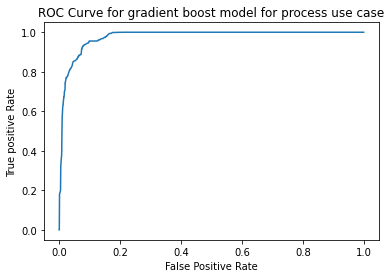

In [108]:

# Returns as a list (false positive rate, true positive rate)
preds_proc = predictions.select('attack','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attack'])))
points_proc = CurveMetrics(preds_proc).get_curve('roc')

plt.figure()
a_value = [a[0] for a in points_proc]
b_value = [b[1] for b in points_proc]
plt.title('ROC Curve for gradient boost model for process use case')
plt.xlabel("False Positive Rate")
plt.ylabel("True positive Rate")
plt.plot(a_value, b_value)

## Q - 2.3.5

## For process case - rebalanced training data

In [109]:
# Separate 0 and 1 classes
train_proc_0 = train_proc[train_proc.attack==0]
train_proc_1 = train_proc[train_proc.attack==1]

# counts of separate classes
count_0 = train_proc_0.count()
count_1 = train_proc_1.count()

# ratio of 0 class
train_proc_0_ratio = (count_1*2/count_0)


#undersampling
#train_proc_1 = train_proc_1.sample(False, 0.2, 12345)
train_proc_0 = train_proc_0.sample(False, train_proc_0_ratio, 12345)

# merging the dataframes
train_proc_downsampled = train_proc_1.union(train_proc_0)


train_proc_downsampled.groupBy('attack').agg(count('attack')).show()

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|       233340|
|     0|       467292|
+------+-------------+



## Retraining the pipeline model (gradient boost) with rebalanced data

In [110]:
train_proc_table = train_proc_downsampled

# Import the libraries
from pyspark.sql.functions import udf
from datetime import datetime

# Create a function that returns the desired string from a timestamp 
def format_timestamp(tss):
    return datetime.fromtimestamp(tss).strftime('%Y-%m-%d %H:%M:%S')

# Create the UDF
format_timestamp_udf = udf(lambda x: format_timestamp(x))

# Finally, apply the function to each element of the 'timestamp' column
train_proc_table = train_proc_table.withColumn('ts', format_timestamp_udf(train_proc_table['ts']))

train_proc_table = train_proc_table.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID','TRUN','TSLPI','TSLPU',\
                     'POLI','NICE','PRI','RTPR','CPUNR','Status','EXC', 'State', 'CPU', 'CMD', 'attack', 'type')






test_proc_table = test_proc

# Finally, apply the function to each element of the 'timestamp' column
test_proc_table = test_proc_table.withColumn('ts', format_timestamp_udf(test_proc_table['ts']))

test_proc_table = test_proc_table.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID','TRUN','TSLPI','TSLPU',\
                     'POLI','NICE','PRI','RTPR','CPUNR','Status','EXC', 'State', 'CPU', 'CMD', 'attack', 'type')


train_proc_table = train_proc_table.withColumn("day", train_proc_table["day"].cast(IntegerType()))
train_proc_table = train_proc_table.withColumn("hour", train_proc_table["hour"].cast(IntegerType()))
train_proc_table = train_proc_table.withColumn("month", train_proc_table["month"].cast(IntegerType()))


test_proc_table = test_proc_table.withColumn("day", test_proc_table["day"].cast(IntegerType()))
test_proc_table = test_proc_table.withColumn("hour", test_proc_table["hour"].cast(IntegerType()))
test_proc_table = test_proc_table.withColumn("month", test_proc_table["month"].cast(IntegerType()))

proc_columns = [ 'CMD', 'State', 'Status', 'POLI']




inputCols = [col for col in proc_columns ]
outputCols = [f"{col}_idx" for col in proc_columns]


stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols).setHandleInvalid("keep")


inputCols_VA = outputCols

for i in ['PID','day', 'hour','month',]:
    inputCols_VA.append(i)
    

stage_2 = VectorAssembler(inputCols=(inputCols_VA),outputCol="features")


# Train a Gradient boosting model.


gradient_boost = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10, maxBins = 100000)

# Chain indexers and tree in a Pipeline
pipeline =  Pipeline(stages=[stage_1,stage_2,gradient_boost])

# Train model.  This also runs the indexers.
model = pipeline.fit(train_proc_table)

# Make predictions.
predictions =  model.transform(test_proc_table)

# Select example rows to display.
selection = predictions.select("features","probability", "attack", "prediction")
selection.show(truncate=False)

+--------------------------------------+----------------------------------------+------+----------+
|features                              |probability                             |attack|prediction|
+--------------------------------------+----------------------------------------+------+----------+
|[73.0,3.0,2.0,1.0,11617.0,3.0,1.0,4.0]|[0.9341221756527873,0.06587782434721268]|0     |0.0       |
|[72.0,3.0,2.0,1.0,10001.0,3.0,1.0,4.0]|[0.9341221756527873,0.06587782434721268]|0     |0.0       |
|[73.0,3.0,2.0,1.0,10002.0,3.0,1.0,4.0]|[0.9341221756527873,0.06587782434721268]|0     |0.0       |
|[77.0,3.0,2.0,1.0,10006.0,3.0,1.0,4.0]|[0.9341221756527873,0.06587782434721268]|0     |0.0       |
|[72.0,3.0,2.0,1.0,10013.0,3.0,1.0,4.0]|[0.9341221756527873,0.06587782434721268]|0     |0.0       |
|[77.0,3.0,2.0,1.0,10024.0,3.0,1.0,4.0]|[0.9341221756527873,0.06587782434721268]|0     |0.0       |
|[77.0,3.0,2.0,1.0,10027.0,3.0,1.0,4.0]|[0.9341221756527873,0.06587782434721268]|0     |0.0       |


# For memory

### Converting timestamp column to datetime to extract day and hour variables for the model

In [111]:
train_mem_table = train_mem_downsampled

# Import the libraries
from pyspark.sql.functions import udf
from datetime import datetime

# Create a function that returns the desired string from a timestamp 
def format_timestamp(tss):
    return datetime.fromtimestamp(tss).strftime('%Y-%m-%d %H:%M:%S')

# Create the UDF
format_timestamp_udf = udf(lambda x: format_timestamp(x))

# Finally, apply the function to each element of the 'timestamp' column
train_mem_table = train_mem_table.withColumn('ts', format_timestamp_udf(train_mem_table['ts']))

train_mem_table = train_mem_table.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID','MINFLT','MAJFLT','VSTEXT',\
                     'VSIZE','RSIZE','VGROW','RGROW','MEM','attack','CMD', 'type')






test_mem_table = test_mem

# Finally, apply the function to each element of the 'timestamp' column
test_mem_table = test_mem_table.withColumn('ts', format_timestamp_udf(test_mem_table['ts']))

test_mem_table = test_mem_table.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID','MINFLT','MAJFLT','VSTEXT',\
                     'VSIZE','RSIZE','VGROW','RGROW','MEM','attack','CMD', 'type')


train_mem_table = train_mem_table.withColumn("day", train_mem_table["day"].cast(IntegerType()))
train_mem_table = train_mem_table.withColumn("hour", train_mem_table["hour"].cast(IntegerType()))
train_mem_table = train_mem_table.withColumn("month", train_mem_table["month"].cast(IntegerType()))


test_mem_table = test_mem_table.withColumn("day", test_mem_table["day"].cast(IntegerType()))
test_mem_table = test_mem_table.withColumn("hour", test_mem_table["hour"].cast(IntegerType()))
test_mem_table = test_mem_table.withColumn("month", test_mem_table["month"].cast(IntegerType()))

### Feature selection and importnace

<AxesSubplot:>

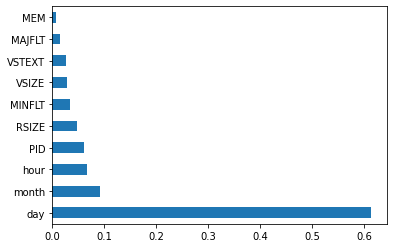

In [112]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline            

X = train_mem_table

k = ['ts','year','CMD','type']

X = X.select([column for column in X.columns if column not in k]).toPandas()
y = X.pop('attack')

model = RandomForestClassifier()
model.fit(X, y)

(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))  

### BUILDING MODEL (DECISION TREE) - String indexing, Vector assembling and decision tree classifier model for the Memory use case

In [113]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col


#string Indexer


mem_columns = ['CMD']


from pyspark.ml.feature import StringIndexer

inputCols = [col for col in mem_columns ]
outputCols = [f"{col}_idx" for col in mem_columns]
#outputCols.append('label')

# TODO: Initialize StringIndexer (use inputCols and outputCols)

stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols).setHandleInvalid("keep")

#TODO call the fit and transform() method to get the encoded results 


from pyspark.ml.feature import VectorAssembler

inputCols_VA = outputCols

for i in ['day', 'hour','month','PID', 'RSIZE', 'MINFLT']:
    inputCols_VA.append(i)
    

stage_2 = VectorAssembler(inputCols=(inputCols_VA),outputCol="features")

# df_indexed = Stage_1.fit(train_proc_downsampled)


# #TODO Display the output, only the output columns

# indexed = df_indexed.transform(train_proc_downsampled)
# indexed.toPandas()
# Train a DecisionTree model.
decision_tree = DecisionTreeClassifier(labelCol='attack', featuresCol = 'features',impurity='gini', maxBins = 100000)




## 2.3 Training and evaluating models

### Stages for the pipeline

In [114]:
# Chain indexers and tree in a Pipeline
pipeline =  Pipeline(stages=[stage_1,stage_2,decision_tree])

# Train model.  This also runs the indexers.
model = pipeline.fit(train_mem_table)

# Make predictions.
predictions =  model.transform(test_mem_table)

# Select example rows to display.
selection = predictions.select("features","probability", "attack", "prediction")
selection.show(truncate=False)

+-----------------------------------+-----------+------+----------+
|features                           |probability|attack|prediction|
+-----------------------------------+-----------+------+----------+
|[142.0,3.0,1.0,4.0,10005.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[142.0,3.0,1.0,4.0,10023.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[155.0,3.0,1.0,4.0,10024.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[151.0,3.0,1.0,4.0,10028.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[142.0,3.0,1.0,4.0,10035.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[151.0,3.0,1.0,4.0,10046.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[151.0,3.0,1.0,4.0,10049.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[155.0,3.0,1.0,4.0,10066.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[151.0,3.0,2.0,4.0,10091.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[151.0,3.0,2.0,4.0,10094.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[151.0,3.0,2.0,4.0,10097.0,0.0,0.0]|[1.0,0.0]  |0     |0.0       |
|[155.0,3.0,2.0,4.0,10111.0,0.0,0.0]|[1.0,0.0]  

### Accuracy, precision, recall and F1 score

In [115]:
# Calculating the elements for the confusion matrix
True_Negative = predictions.filter('prediction = 0.0 AND attack = 0').count()
True_Positive = predictions.filter('prediction = 1.0 AND attack = 1').count()
False_Negative = predictions.filter('prediction = 0.0 AND attack = 1').count()
False_Positive = predictions.filter('prediction = 1.0 AND attack = 0').count()

# showing the confusion matrix
predictions.groupBy('attack', 'prediction').count().show()
# calculate metrics by the confusion matrix
accuracy = (True_Positive+True_Negative)/(True_Positive+True_Negative+False_Positive+False_Negative)
precision = True_Positive/(True_Positive+False_Positive)
recall = True_Positive/(True_Positive+False_Negative)
f1 = 2/((1/recall)+(1/precision))

#Printing out the various metrics calculated above
print("Accuracy for the model is: ",accuracy)
print("Precision for the model is: ",precision)
print("Recall for the model is: ",recall)
print("F1 score for the model is: ",f1)

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  1445|
|     0|       0.0|337840|
|     1|       1.0| 39541|
|     0|       1.0| 20869|
+------+----------+------+

Accuracy for the model is:  0.9441724314790028
Precision for the model is:  0.6545439496772057
Recall for the model is:  0.9647440589469575
F1 score for the model is:  0.7799321472247426


In [116]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(labelCol="attack", rawPredictionCol="prediction", metricName = 'areaUnderROC')
auc_dt = evaluator.evaluate(predictions)
print(auc_dt)
print(evaluator.getMetricName())

0.9532829907261934
areaUnderROC


### top-5 most important features in model

In [117]:
## Reference - https://kb.databricks.com/machine-learning/extract-feature-info.html?fbclid=IwAR1fuedxIqlif4oz150ERk3iP09IfSwGYacl3HVnUooMQhbxXGf537IasCk

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stage_1, stage_2, decision_tree])
DTmodel = pipeline.fit(train_mem_table)
va = DTmodel.stages[-2]
tree = DTmodel.stages[-1]

display(tree) #visualize the decision tree model
print(tree.toDebugString) #print the nodes of the decision tree model

d_list = list(zip(va.getInputCols(), tree.featureImportances))

sorted(d_list,key=lambda x:(-x[1],x[0]))[0:5]

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_aa40a297fd01, depth=5, numNodes=21, numClasses=2, numFeatures=7

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_aa40a297fd01, depth=5, numNodes=21, numClasses=2, numFeatures=7
  If (feature 1 <= 24.5)
   Predict: 0.0
  Else (feature 1 > 24.5)
   If (feature 1 <= 29.5)
    If (feature 2 <= 19.5)
     If (feature 1 <= 28.5)
      If (feature 1 <= 27.5)
       Predict: 1.0
      Else (feature 1 > 27.5)
       Predict: 0.0
     Else (feature 1 > 28.5)
      Predict: 1.0
    Else (feature 2 > 19.5)
     If (feature 1 <= 26.5)
      Predict: 0.0
     Else (feature 1 > 26.5)
      If (feature 1 <= 28.5)
       Predict: 1.0
      Else (feature 1 > 28.5)
       Predict: 0.0
   Else (feature 1 > 29.5)
    If (feature 2 <= 0.5)
     If (feature 0 in {2.0,4.0,5.0,6.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,16.0,17.0,18.0,19.0,21.0,23.0,24.0,25.0,26.0,29.0,33.0,34.0,35.0,37.0,38.0,40.0,44.0,46.0,51.0,57.0,60.0,62.0,64.0,65.0,67.0,69.0,70.0,71.0,74.0,75.0,77.0,82.0,84.0,87.0,90.0,91.0,93.0,96.0,97.0,98.0,99.0,100.0,104.0,108.0,109.0,114.0,115.0,118.0,122.0,

[('day', 0.9815906203606892),
 ('hour', 0.017944290316531726),
 ('CMD_idx', 0.0004650893227790397),
 ('MINFLT', 0.0),
 ('PID', 0.0)]

## 2.3 Training and evaluating models

# Gradient boosting model

In [118]:
# Train a Gradient boosting model.


gradient_boost = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10, maxBins = 100000)

# Chain indexers and tree in a Pipeline
pipeline =  Pipeline(stages=[stage_1,stage_2,gradient_boost])

# Train model.  This also runs the indexers.
model = pipeline.fit(train_mem_table)

# Make predictions.
predictions =  model.transform(test_mem_table)

# Select example rows to display.
selection = predictions.select("features","probability", "attack", "prediction")
selection.show(truncate=False)

+-----------------------------------+---------------------------------------+------+----------+
|features                           |probability                            |attack|prediction|
+-----------------------------------+---------------------------------------+------+----------+
|[142.0,3.0,1.0,4.0,10005.0,0.0,0.0]|[0.934122175652786,0.06587782434721401]|0     |0.0       |
|[142.0,3.0,1.0,4.0,10023.0,0.0,0.0]|[0.934122175652786,0.06587782434721401]|0     |0.0       |
|[155.0,3.0,1.0,4.0,10024.0,0.0,0.0]|[0.934122175652786,0.06587782434721401]|0     |0.0       |
|[151.0,3.0,1.0,4.0,10028.0,0.0,0.0]|[0.934122175652786,0.06587782434721401]|0     |0.0       |
|[142.0,3.0,1.0,4.0,10035.0,0.0,0.0]|[0.934122175652786,0.06587782434721401]|0     |0.0       |
|[151.0,3.0,1.0,4.0,10046.0,0.0,0.0]|[0.934122175652786,0.06587782434721401]|0     |0.0       |
|[151.0,3.0,1.0,4.0,10049.0,0.0,0.0]|[0.934122175652786,0.06587782434721401]|0     |0.0       |
|[155.0,3.0,1.0,4.0,10066.0,0.0,0.0]|[0.

### Accuracy, precision, recall and F1 score

In [119]:
# Calculating the elements for the confusion matrix
True_Negative = predictions.filter('prediction = 0.0 AND attack = 0').count()
True_Positive = predictions.filter('prediction = 1.0 AND attack = 1').count()
False_Negative = predictions.filter('prediction = 0.0 AND attack = 1').count()
False_Positive = predictions.filter('prediction = 1.0 AND attack = 0').count()

# showing the confusion matrix
predictions.groupBy('attack', 'prediction').count().show()
# calculate metrics by the confusion matrix
accuracy = (True_Positive+True_Negative)/(True_Positive+True_Negative+False_Positive+False_Negative)
precision = True_Positive/(True_Positive+False_Positive)
recall = True_Positive/(True_Positive+False_Negative)
f1 = 2/((1/recall)+(1/precision))

#Printing out the various metrics calculated above
print("Accuracy for the model is: ",accuracy)
print("Precision for the model is: ",precision)
print("Recall for the model is: ",recall)
print("F1 score for the model is: ",f1)

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|   462|
|     0|       0.0|342427|
|     1|       1.0| 40524|
|     0|       1.0| 16282|
+------+----------+------+

Accuracy for the model is:  0.9581080573937627
Precision for the model is:  0.7133753476745415
Recall for the model is:  0.9887278582930756
F1 score for the model is:  0.8287794502617801


In [120]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(labelCol="attack", rawPredictionCol="prediction", metricName = 'areaUnderROC')
auc_gb = evaluator.evaluate(predictions)
print(auc_gb)
print(evaluator.getMetricName())

0.9716686524738031
areaUnderROC


### top-5 most important features in model

In [121]:
## Reference - https://kb.databricks.com/machine-learning/extract-feature-info.html?fbclid=IwAR1fuedxIqlif4oz150ERk3iP09IfSwGYacl3HVnUooMQhbxXGf537IasCk

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stage_1, stage_2, gradient_boost])
DTmodel = pipeline.fit(train_mem_table)
va = DTmodel.stages[-2]
tree = DTmodel.stages[-1]

display(tree) #visualize the decision tree model
print(tree.toDebugString) #print the nodes of the decision tree model

d_list = list(zip(va.getInputCols(), tree.featureImportances))

sorted(d_list,key=lambda x:(-x[1],x[0]))[0:5]

GBTClassificationModel: uid = GBTClassifier_b6796a0d0ce2, numTrees=10, numClasses=2, numFeatures=7

GBTClassificationModel: uid = GBTClassifier_b6796a0d0ce2, numTrees=10, numClasses=2, numFeatures=7
  Tree 0 (weight 1.0):
    If (feature 1 <= 24.5)
     Predict: -1.0
    Else (feature 1 > 24.5)
     If (feature 1 <= 29.5)
      If (feature 2 <= 19.5)
       If (feature 0 in {0.0,2.0,4.0,5.0,6.0,7.0,8.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,22.0,42.0,55.0,60.0,71.0,86.0,117.0,119.0,134.0,148.0,152.0,161.0,162.0,163.0,165.0,167.0,168.0,175.0,181.0,200.0,209.0,210.0,213.0,218.0,219.0,220.0,222.0,235.0,244.0,246.0,248.0,253.0,262.0,274.0,275.0,286.0,299.0,300.0,311.0,313.0,315.0,368.0})
        If (feature 1 <= 28.5)
         Predict: 0.3760797342192691
        Else (feature 1 > 28.5)
         Predict: 0.7524322086524529
       Else (feature 0 not in {0.0,2.0,4.0,5.0,6.0,7.0,8.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,22.0,42.0,55.0,60.0,71.0,86.0,117.0,119.0,134.0,148.0,152.0,161.0,162.0,163.0,165.0,167.0,168.0,175.0,181.0,200.0,209.0,210.0,213.0,218.0,219.0,220.0,222.0,235.0,244.0,24

[('day', 0.6503323413562049),
 ('hour', 0.2503761218785895),
 ('CMD_idx', 0.04046628369046017),
 ('MINFLT', 0.03069514641712191),
 ('PID', 0.023833804773930548)]

## Discussion of which pipleline model is better

#### For the memory case after building the decision tree model and gradient boost model, we can see that the gradient boost model has better accuracy, precision, recall, f1 and most importantly AUC score. Higher AUC score indicates that the gradient boost model is able to distinguish between the attacks and non attacks more efficiently than the decision tree model (it has a good measure of separatability). precision determines the ratio of actual positives against predicted positive, i.e how accurat ethe model is. the gradient boost model has higher precision scores as well. Recall determines Actual Positives the model captures through labeling it as True Positive. Gradient boost model also excels in this category. overall the gradient boost model is better than the decision tree model after considering all the performamce metrices.

## ROC curve for gradient boost model memory case

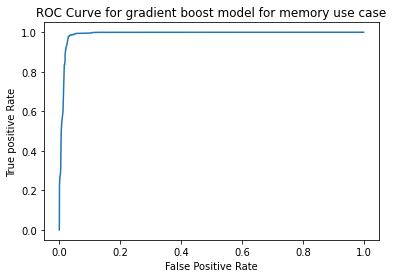

In [122]:
# Returns as a list (false positive rate, true positive rate)
preds_mem = predictions.select('attack','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attack'])))
points_mem = CurveMetrics(preds_mem).get_curve('roc')

plt.figure()
a_value = [a[0] for a in points_mem]
b_value = [b[1] for b in points_mem]
plt.title('ROC Curve for gradient boost model for memory use case')
plt.xlabel("False Positive Rate")
plt.ylabel("True positive Rate")
plt.plot(a_value, b_value)


## AUC score can be interpreted as - if someone is randomly choosing a positive case and a negative case, the probability of the positive case outranikng the negative case determined by the classifier is provided by the AUC score. Order by predicted values determines rank. How exact a clasiffier is, is determined by precision. A low precision can indicate a large number of False Positives. the F1 score portrays the balance between the precision and the recall.

## Area under ROC Curve is a performance metric for measuring the ability of a binary classifier to differentiate between positive and negative classes. it is proper metric to evaluate models. close to 1 AUC would indicate a perfect classifier.

# Q 2.3.5

### Using the pipeline model you selected in the previous step, re-train the pipeline model using a bigger set of rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case.
 

## For memory case - rebalanced training data

In [123]:

# Separate 0 and 1 classes
train_mem_0 = train_mem[train_mem.attack==0]
train_mem_1 = train_mem[train_mem.attack==1]

# counts of separate classes
count_0 = train_mem_0.count()
count_1 = train_mem_1.count()

# ratio of 0 class
train_mem_0_ratio = (count_1*2/count_0)


#undersampling
#train_mem_1 = train_mem_1.sample(False, 0.2, 12345)
train_mem_0 = train_mem_0.sample(False, train_mem_0_ratio, 12345)

# merging the dataframes
train_mem_downsampled = train_mem_1.union(train_mem_0)


train_mem_downsampled.groupBy('attack').agg(count('attack')).show()

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|       164637|
|     0|       329626|
+------+-------------+



## Retraining the pipeline model (gradient boost) with rebalanced data

In [124]:
train_mem_table = train_mem_downsampled

# Import the libraries
from pyspark.sql.functions import udf
from datetime import datetime

# Create a function that returns the desired string from a timestamp 
def format_timestamp(tss):
    return datetime.fromtimestamp(tss).strftime('%Y-%m-%d %H:%M:%S')

# Create the UDF
format_timestamp_udf = udf(lambda x: format_timestamp(x))

# Finally, apply the function to each element of the 'timestamp' column
train_mem_table = train_mem_table.withColumn('ts', format_timestamp_udf(train_mem_table['ts']))

train_mem_table = train_mem_table.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID','MINFLT','MAJFLT','VSTEXT',\
                     'VSIZE','RSIZE','VGROW','RGROW','MEM','attack','CMD', 'type')






test_mem_table = test_mem

# Finally, apply the function to each element of the 'timestamp' column
test_mem_table = test_mem_table.withColumn('ts', format_timestamp_udf(test_mem_table['ts']))

test_mem_table = test_mem_table.select('ts', substring('ts', 1,4).alias('year'), \
                  substring('ts', 6,2).alias('month'), \
                  substring('ts', 9,2).alias('day'),\
                    substring('ts', 12,2).alias('hour'),'PID','MINFLT','MAJFLT','VSTEXT',\
                     'VSIZE','RSIZE','VGROW','RGROW','MEM','attack','CMD', 'type')


train_mem_table = train_mem_table.withColumn("day", train_mem_table["day"].cast(IntegerType()))
train_mem_table = train_mem_table.withColumn("hour", train_mem_table["hour"].cast(IntegerType()))
train_mem_table = train_mem_table.withColumn("month", train_mem_table["month"].cast(IntegerType()))


test_mem_table = test_mem_table.withColumn("day", test_mem_table["day"].cast(IntegerType()))
test_mem_table = test_mem_table.withColumn("hour", test_mem_table["hour"].cast(IntegerType()))
test_mem_table = test_mem_table.withColumn("month", test_mem_table["month"].cast(IntegerType()))


mem_columns = ['CMD']


from pyspark.ml.feature import StringIndexer

inputCols = [col for col in mem_columns ]
outputCols = [f"{col}_idx" for col in mem_columns]
#outputCols.append('label')

# TODO: Initialize StringIndexer (use inputCols and outputCols)

stage_1 = StringIndexer(inputCols=inputCols, outputCols=outputCols).setHandleInvalid("keep")

#TODO call the fit and transform() method to get the encoded results 


from pyspark.ml.feature import VectorAssembler

inputCols_VA = outputCols

for i in ['day', 'hour','month','PID', 'RSIZE', 'MINFLT']:
    inputCols_VA.append(i)
    

stage_2 = VectorAssembler(inputCols=(inputCols_VA),outputCol="features")


# Train a Gradient boosting model.


gradient_boost = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=10, maxBins = 100000)

# Chain indexers and tree in a Pipeline
pipeline =  Pipeline(stages=[stage_1,stage_2,gradient_boost])

# Train model.  This also runs the indexers.
model = pipeline.fit(train_mem_table)

# Make predictions.
predictions =  model.transform(test_mem_table)

# Select example rows to display.
selection = predictions.select("features","probability", "attack", "prediction")
selection.show(truncate=False)

+-----------------------------------+----------------------------------------+------+----------+
|features                           |probability                             |attack|prediction|
+-----------------------------------+----------------------------------------+------+----------+
|[146.0,3.0,1.0,4.0,10005.0,0.0,0.0]|[0.9341221756527938,0.06587782434720624]|0     |0.0       |
|[146.0,3.0,1.0,4.0,10023.0,0.0,0.0]|[0.9341221756527938,0.06587782434720624]|0     |0.0       |
|[154.0,3.0,1.0,4.0,10024.0,0.0,0.0]|[0.9341221756527938,0.06587782434720624]|0     |0.0       |
|[149.0,3.0,1.0,4.0,10028.0,0.0,0.0]|[0.9341221756527938,0.06587782434720624]|0     |0.0       |
|[146.0,3.0,1.0,4.0,10035.0,0.0,0.0]|[0.9341221756527938,0.06587782434720624]|0     |0.0       |
|[149.0,3.0,1.0,4.0,10046.0,0.0,0.0]|[0.9341221756527938,0.06587782434720624]|0     |0.0       |
|[149.0,3.0,1.0,4.0,10049.0,0.0,0.0]|[0.9341221756527938,0.06587782434720624]|0     |0.0       |
|[154.0,3.0,1.0,4.0,10066.0,0.

In [125]:
#sc.stop()

## 3. Knowledge sharing (10%)

In [126]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

## 

## screenshot from Spark UI for running a simple KMeans model training

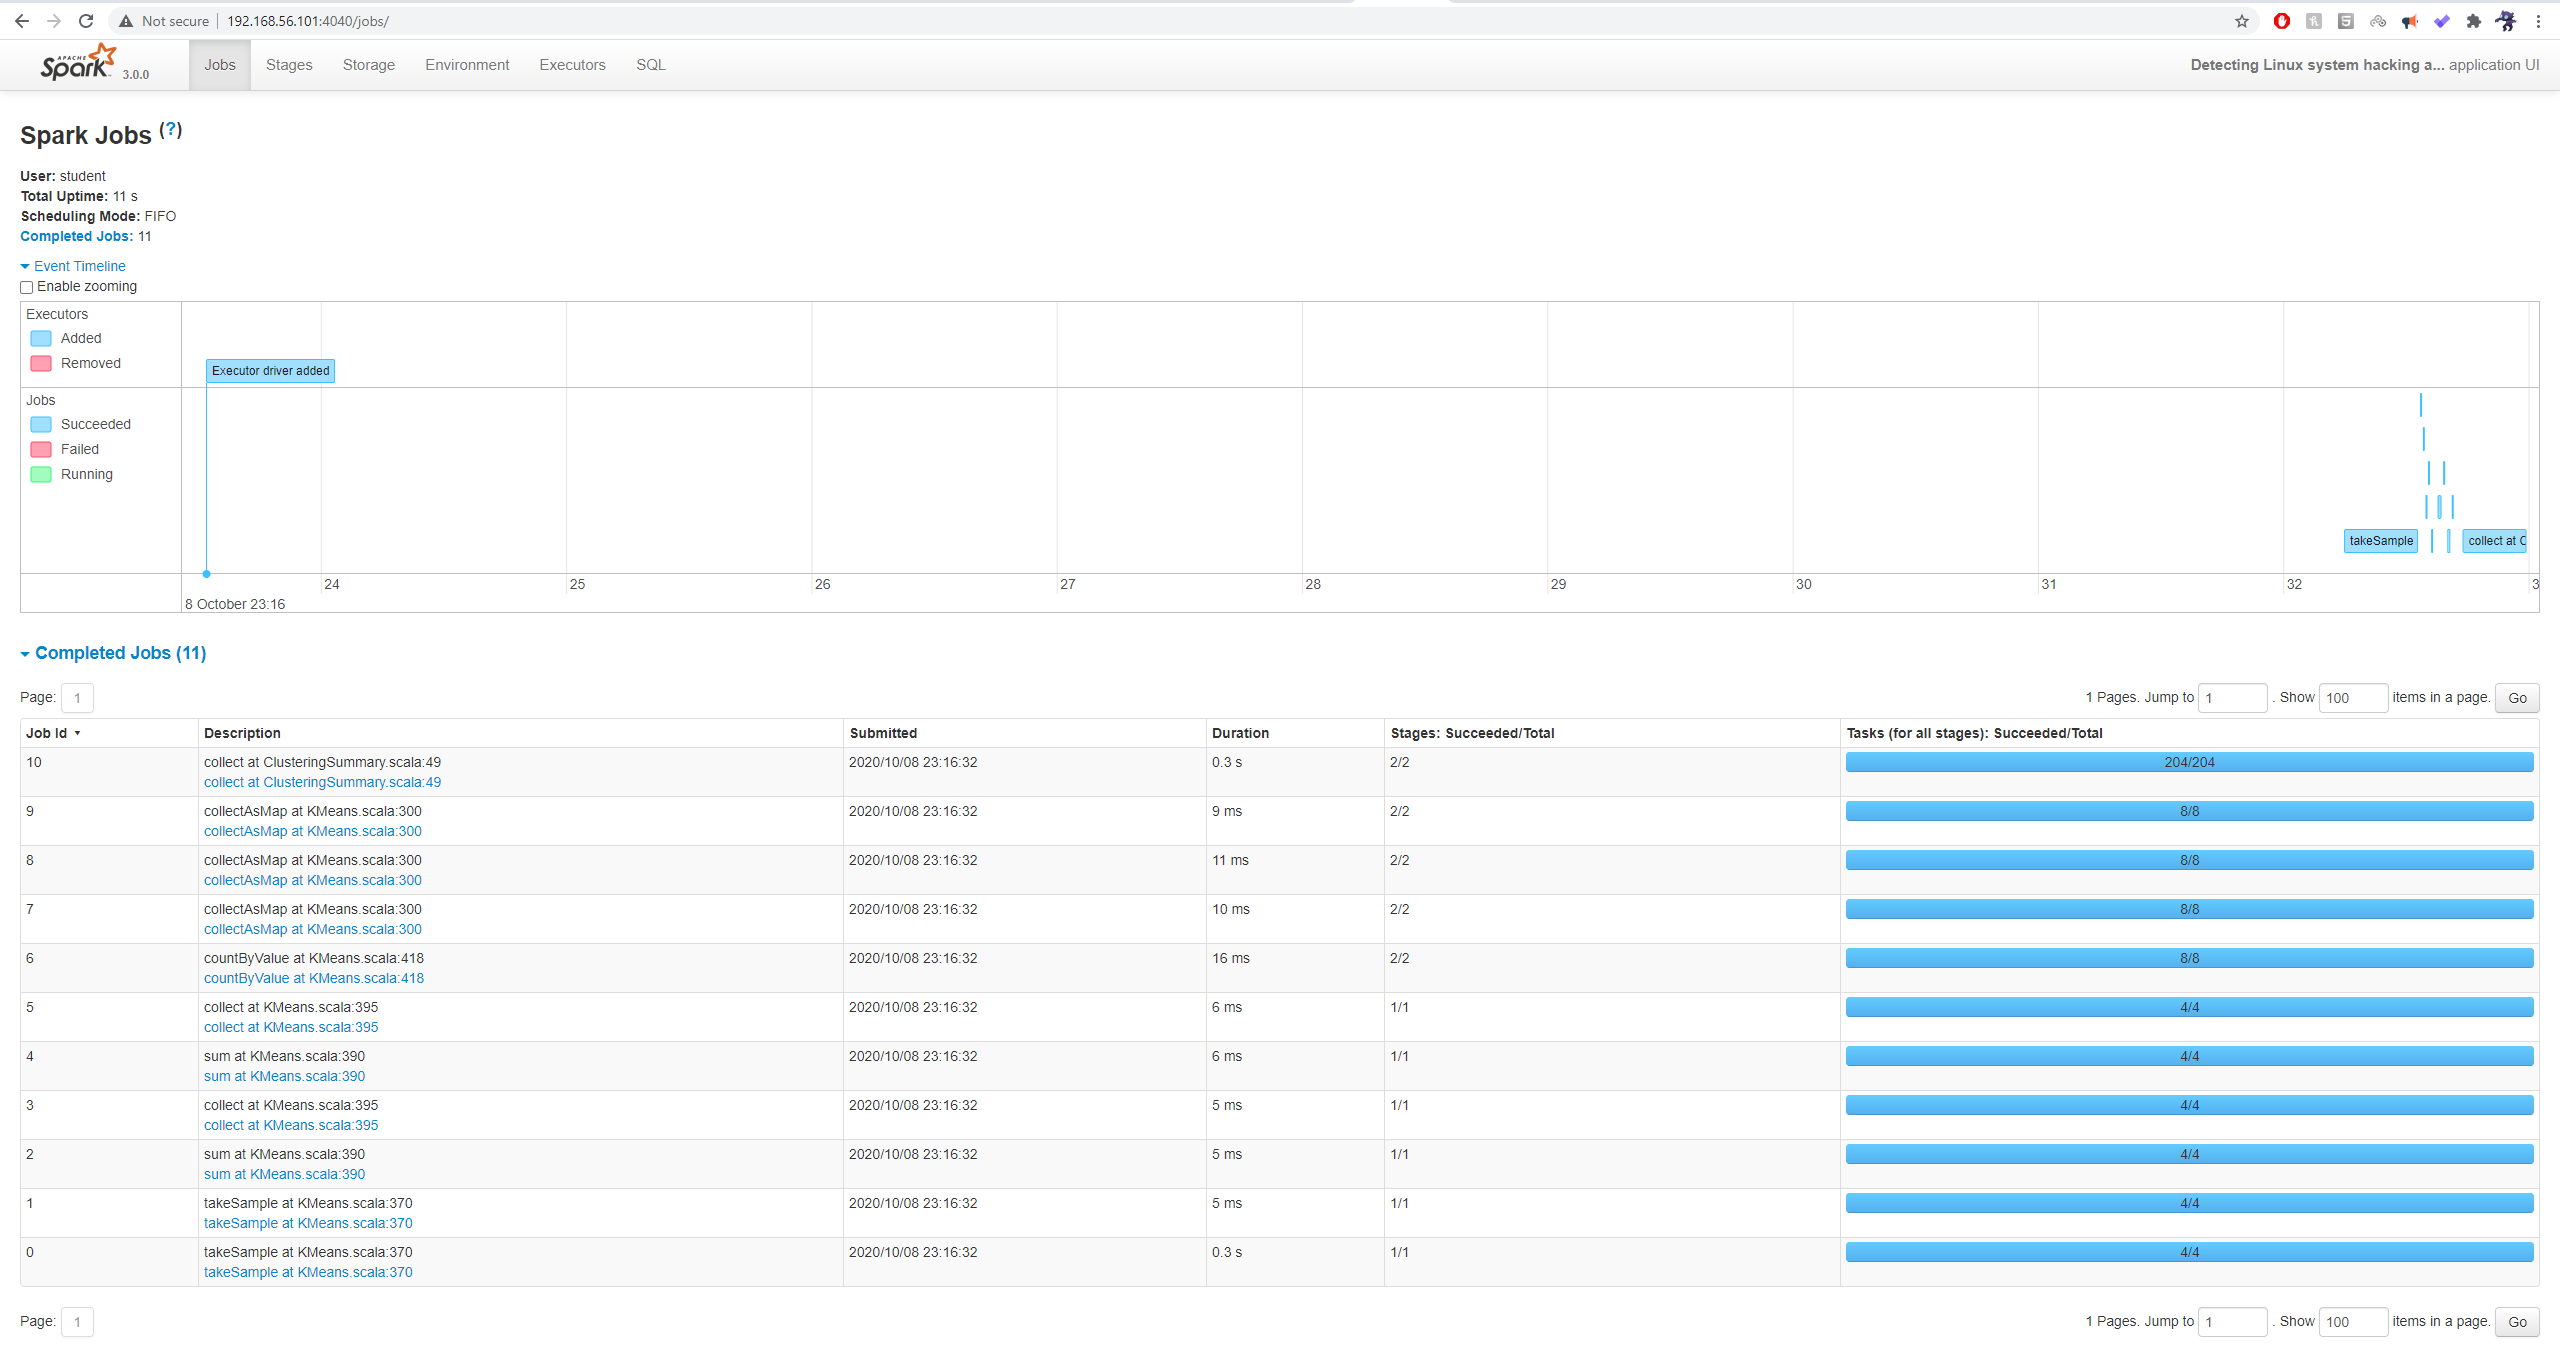

In [127]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "sparkUI.PNG", width = 1200, height = 600)

## 3.2 Combining the KMeans algorithm from the lecture, explain what each job in Spark UI represents (9.5%)

### We can observe from the spark UI that K-means clustering algorithm took 11 jobs to complete the kmeans clustering for the iris data sample. the data is divided into 4 paritions, this is because my VM setup is using 4 logical processors. First 2 jobs were taking the sample of the data. the following jobs are summing at kmenas followed by a collect action. next job is counting by value followed by collectAsMap. finally the clustering summary consists of the summary metrics of 200 completed tasks. 

### the Kmeans algoriths specifies the k number of clusters, in our case we specified 3 (it will form 3 clusters). it then tried to estimate the centeroid of the k seed cluster. it then iterated through the data points and assigns each data to the nearest centroid (mean). at each step clusters may loose of gain members and each cluster claculated the centeroid again at each step. this iteration is repeated until the clusters are stable which means that clusters dont change the datapoints that they hold.